# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

- **Заказчик:** сеть отелей «Как в гостях»;
- **Цель:** разработать модель для предсказания отказа брони;
- **Дополнительные сведения:**
 - Есть несколько типов номеров:
    - **категория A:** за ночь — 1 000, разовое обслуживание — 400;
    - **категория B:** за ночь — 800, разовое обслуживание — 350;
    - **категория C:** за ночь — 600, разовое обслуживание — 350;
    - **категория D:** за ночь — 550, разовое обслуживание — 150;
    - **категория E:** за ночь — 500, разовое обслуживание — 150;
    - **категория F:** за ночь — 450, разовое обслуживание — 150;
    - **категория G:** за ночь — 350, разовое обслуживание — 150.
 - Используются сезонные коэффициенты: **весной и осенью цены повышаются на 20%, летом — на 40%.**
 - **Убытки** отеля в случае отмены брони номера — это **стоимость одной уборки и одной ночи с учётом сезонного коэффициента**.
 - Если клиент снял номер надолго, то **убираются каждые два дня**.
 - На разработку системы прогнозирования заложен **бюджет — 400 000**. Внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше выручки, которую система принесёт компании.
- **Путь к данным:**
 - **/datasets/hotel_train.csv** — данные для обучения модели.
 - **/datasets/hotel_test.csv** — данные для тестирования модели.

*В таблицах **hotel_train** и **hotel_test** содержатся одинаковые столбцы*.
- **Описание данных:**
    - **id** — номер записи;
    - **adults** — количество взрослых постояльцев;
    - **arrival_date_year** — год заезда;
    - **arrival_date_month** — месяц заезда;
    - **arrival_date_week_number** — неделя заезда;
    - **arrival_date_day_of_month** — день заезда;
    - **babies** — количество младенцев;
    - **booking_changes** — количество изменений параметров заказа;
    - **children** — количество детей от 3 до 14 лет;
    - **country** — гражданство постояльца;
    - **customer_type** — тип заказчика:
        - **Contract** — договор с юридическим лицом;
        - **Group** — групповой заезд;
        - **Transient** — не связано с договором или групповым заездом;
        - **Transient-party** — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
    - **days_in_waiting_list** — сколько дней заказ ожидал подтверждения;
    - **distribution_channel** — канал дистрибуции заказа;
    - **is_canceled** — отмена заказа;
    - **is_repeated_guest** — признак того, что гость бронирует номер второй раз;
    - **lead_time** — количество дней между датой бронирования и датой прибытия;
    - **meal** — опции заказа:
        - **SC** — нет дополнительных опций;
        - **BB** — включён завтрак;
        - **HB** — включён завтрак и обед;
        - **FB** — включён завтрак, обед и ужин.
    - **previous_bookings_not_canceled** — количество подтверждённых заказов у клиента;
    - **previous_cancellations** — количество отменённых заказов у клиента;
    - **required_car_parking_spaces** — необходимость места для автомобиля;
    - **reserved_room_type** — тип забронированной комнаты;
    - **stays_in_weekend_nights** — количество ночей в выходные дни;
    - **stays_in_week_nights** — количество ночей в будние дни;
    - **total_nights** — общее количество ночей;
    - **total_of_special_requests** — количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [1]:
# Импортируем пандас для работы с табличными данными
import pandas as pd

In [2]:
# Читаем данные из файла и сохраняем их в переменную
# --- данные для обучения модели
dt_train = pd.read_csv('/datasets/hotel_train.csv')
# --- данные для тестирования модели
dt_test = pd.read_csv('/datasets/hotel_test.csv')

In [3]:
# Убираем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

In [4]:
# Выведем 3 случайные записи
# --- обучающие данные
display(dt_train.sample(3, random_state=0))
# --- тестовые данные
display(dt_test.sample(3, random_state=0))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
41360,59750,0,7.0,2015,October,41,7,0,3,2.0,0.0,0.0,BB,ITA,TA/TO,0,0,0,A,0,0,Contract,0,2,3
37015,55370,1,286.0,2015,July,31,30,0,2,2.0,0.0,0.0,BB,PRT,TA/TO,1,1,0,A,0,0,Transient-Party,0,0,2
10616,13167,0,17.0,2016,March,10,3,0,1,2.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,0,1


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18428,80470,0,3.0,2017,May,19,8,1,2,1.0,0.0,0.0,BB,ITA,Corporate,1,0,1,D,0,0,Transient,0,1,3
74,6162,1,3.0,2017,January,3,19,0,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,2,1
416,6509,1,312.0,2017,March,10,5,2,5,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,7


**Вывод:** данные были загружены.

### Шаг 2. Предобработка и исследовательский анализ данных

#### Первичный осмотр данных

##### Осмотр

In [5]:
# Выводим основную информацию о данных
dt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
# Выводим основную информацию о данных
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

##### Поиск дублей

In [7]:
# Проверяем наличие полных деликатов
print('Количество полных дублей в обучающих данных:', len(dt_train[dt_train.duplicated()]))
print('Количество полных дублей в тестовых данных:', len(dt_test[dt_test.duplicated()]))

Количество полных дублей в обучающих данных: 0
Количество полных дублей в тестовых данных: 0


In [8]:
# Проверяем неявные дубликаты по идентификатору
print('Количество дубликатов по идентификатору в обучающих данных:', len(dt_train['id']) - len(dt_train['id'].unique()))
print('Количество дубликатов по идентификатору в тестовых данных:', len(dt_test['id']) - len(dt_test['id'].unique()))

Количество дубликатов по идентификатору в обучающих данных: 0
Количество дубликатов по идентификатору в тестовых данных: 0


In [9]:
print('Доля полных дубликатов без id (обучающая выборка):', dt_train.drop('id', axis=1).duplicated().mean())
print('Доля полных дубликатов без id (тестова выборка):', dt_test.drop('id', axis=1).duplicated().mean())

Доля полных дубликатов без id (обучающая выборка): 0.3277223320915544
Доля полных дубликатов без id (тестова выборка): 0.23809083055658398


Вполне может быть, что в выборку случайно попали дубли, а может быть и такое, что в номер просто въехали в один и тот же день клиенты с одинаковыми параметрами.<br>

От них можно избавиться, но перед этим, стоило бы проконсультироваться с коллегами, могло-ли такое случиться в действительности.<br>

В любом случае, данные, которые являются дублями не повредят модели МЛ, она просто не вынесет для себя новую информацию. Это только замедлит время обучения.

##### Проверка категориальных переменных

In [10]:
# Выводим уникальные значения категорий
display(dt_train['meal'].value_counts().to_frame().T)
display(dt_train['arrival_date_month'].value_counts().to_frame().T)
display(dt_train['country'].value_counts().to_frame().T)
display(dt_train['distribution_channel'].value_counts().to_frame().T)
display(dt_train['reserved_room_type'].value_counts().to_frame().T)
display(dt_train['customer_type'].value_counts().to_frame().T)

,BB,HB,SC,SC,FB
meal,51697,7292,5274,515,451


,October,September,August,November,July,December,April,May,June,March,February,January
arrival_date_month,9255,8782,6678,5761,5718,5497,4804,4677,4659,4148,3358,1892


,PRT,FRA,GBR,ESP,DEU,ITA,IRL,BEL,NLD,BRA,USA,CHE,AUT,SWE,POL,CHN,CN,ISR,RUS,NOR,ROU,FIN,DNK,TUR,AUS,AGO,LUX,MAR,HUN,JPN,CZE,ARG,IND,GRC,SRB,KOR,DZA,HRV,IRN,BGR,THA,UKR,EST,SVN,MEX,SVK,NZL,LTU,CHL,COL,ZAF,MOZ,LVA,TUN,SGP,ARE,TWN,EGY,ISL,MYS,VEN,SAU,IDN,NGA,CYP,LBN,HKG,CPV,PER,CRI,MLT,IRQ,JOR,BLR,PHL,ECU,GIB,OMN,KAZ,URY,BIH,KWT,GEO,MKD,AZE,BOL,BGD,TJK,PRI,ALB,LBY,CMR,QAT,ARM,GNB,PAK,VNM,MUS,JEY,MDV,BRB,PAN,GGY,MNE,SEN,GAB,TMP,SUR,TZA,LKA,DOM,MCO,GLP,KHM,MAC,KEN,MWI,JAM,LIE,CIV,ATA,MLI,PLW,UZB,ABW,BWA,SYR,PYF,BFA,NIC,ZWE,CYM,ZMB,ETH,RWA,MMR,SLV,CUB,NAM,IMN,HND,AND,PRY,STP,SYC,GUY,VGB,LCA,DMA,BHR,BDI,UGA,SMR,KNA,BEN
country,28831,5974,5109,4900,3887,2327,1445,1245,1166,1088,1008,874,716,544,531,526,488,375,296,261,249,241,201,169,168,140,134,125,121,117,112,107,88,81,81,68,62,54,52,48,48,46,45,45,44,44,44,43,42,36,36,34,30,29,26,26,25,24,21,21,20,19,19,18,18,18,16,15,15,12,12,12,12,11,10,10,10,10,10,10,10,10,10,9,9,9,9,8,8,7,7,6,6,6,6,6,5,5,5,5,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,TA/TO,Direct,Corporate,GDS
distribution_channel,54454,6853,3823,99


,A,D,E,F,B,G,C
reserved_room_type,50501,9387,2448,1213,860,592,228


,Transient,Transient-Party,Contract,Group
customer_type,45493,16703,2746,287


##### Выводы первичного осмотра данных

В результате осмотра данных, были выявлены следующие факты:
- Размер обучающих данных: **25 столбцов, 65229 строк**;
- Размер тестовых данных: **25 столбцов, 32412 строк**;
- Пропуски (обучающие/тестовые данные): **отсутствуют**;
- Дубликаты (обучающие/тестовые данные): **отсутствуют**;
- Категориальные переменные: **есть проблема в виде хранения повторяющихся категорий как строк**.

#### Предобработка данных

По результатам анализа, была выявлена только проблема с некоторыми типами переменных. Исправим это:

In [11]:
# Изменяем типы параметров

# --- обучающие данные
dt_train['adults'] = dt_train['adults'].astype('int')
dt_train['babies'] = dt_train['babies'].astype('int')
dt_train['country'] = dt_train['country'].str.strip()
dt_train['reserved_room_type'] = dt_train['reserved_room_type'].str.strip()
dt_train['meal'] = dt_train['meal'].str.strip()

# --- тестовые данные

dt_test['adults'] = dt_test['adults'].astype('int')
dt_test['babies'] = dt_test['babies'].astype('int')
dt_test['children'] = dt_test['children'].astype('int')
dt_test['country'] = dt_test['country'].str.strip()
dt_test['reserved_room_type'] = dt_test['reserved_room_type'].str.strip()
dt_test['meal'] = dt_test['meal'].str.strip()

#### Исследовательский анализ

In [12]:
# Выведем описательную статистику о данных
dt_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Получили представление о структуре данных. Рассмотрим каждый параметр по отдельности и с визуализацией:

In [13]:
# Библиотека для красивых графиков
import seaborn as sns
# Библиотека для более тонкой настройки графиков
import matplotlib.pyplot as plt
# Делаем красивый стиль
sns.set_style("darkgrid")

In [14]:
# Функция для рисования гистограмм
def draw_hist(data, column, bins=None, target_column=None, figsize=(15,5), 
              title=None, xlabel='Значение', ylabel='Количество', percent_size=None,
              legend=['Количество клиентов', 'Доля отменённых заказов'], rot=0):
    '''
    Столбчатый график для переменной. Позволяет показать долю целевой переменной для каждого столбца.
            Параметры:
                    data (DataFrame): источник данных для постороения графика.
                    column (str): название на графике.
                    bins (int): количество корзин гистограммы. Значение ставится,
                        если переменная является непрерывной.
                    target_column (str): столбец целевой переменной. Она должна быть бинарной (0,1).
                        Если данный параметр указан, то на графике будет отображена доля положиетльного класса в каждом столбце.
                    figsize (tuple): размер графика.
                    title (str): заголовок графика.
                    xlabel (str): надпись по оси X.
                    ylabel (str): надпись по оси Y.
                    percent_size (float): если значение указано, будет выводт процентов рядом с каждым столбцом.
                    legend (list): список с обозначениями перменных.
    '''
    # Создаём копию таблицы
    data = data.copy()
    
    # Определяем цвет графика на основании столбца
    color = plt.cm.get_cmap('viridis')(data.columns.get_loc(column)/len(data.columns))  
    
    # Если переменная является непрерывной делим её на интервалы
    if bins != None:  
        # столбец с интервалами
        range_column = 'range_'+column
        
        # Создаем временный столбец с диапазонами в заданном количестве
        data[range_column] = pd.cut(data[column], bins)
        
        # Столбец, с которым будем работать
        current_column = 'present_'+range_column
        # Выбираем среднюю точку интервала
        data[current_column] = data[range_column].apply(lambda x: round(x.mid))
    else:
        # Назначаем количество столбцов
        bins = len(data[column].unique())
        # Текущий столбец, с которым будем работать
        current_column = column

    # Отображать долю положительного класса
    if target_column != None:
        # Создаем сводную таблицу
        summary_data = data.groupby(current_column)[target_column].agg(['count', 'sum'])
        percent_column = 'part_positive_class_' + target_column
        # Высчитываем долю положительного класса
        summary_data[percent_column] = summary_data['sum'] / summary_data['count']  
        # Выводим основной график
        ax = summary_data['count'].plot(kind='bar', figsize=figsize, color=color, alpha=0.3, zorder=1)
        # Выводим дополнительный c долями
        ax = summary_data['sum'].plot(kind='bar', figsize=figsize, color='red', alpha=0.5, zorder=2, ax=ax)
    else:
        # Создаем сводную таблицу
        summary_data = data.groupby(current_column)[current_column].agg(['count', 'sum'])
        percent_column = 'part_positive_class_' + current_column
        # Высчитываем долю
        summary_data[percent_column] = summary_data['count'] / len(data)
        ax = data.groupby(current_column)[current_column].count().plot(kind='bar', figsize=(figsize), color=color, zorder=1)
     
    # Выводим заголовок графика
    ax.set_title(title, fontsize = 20)
    # Выводим подпись оси X
    ax.set_xlabel(xlabel, fontsize = 15)
    # Выводим подпись оси Y
    ax.set_ylabel(ylabel, fontsize = 15)
    # Выводим легенду
    ax.legend(legend)
    # Поворачиваем подписи по оси X
    plt.xticks(rotation=rot)
    
    # Если нужно выводить проценты
    if percent_size != None:
        # Добавляем текстовые метки
        for i in range(bins):
            # Если мы выводим долю от целевой переменной
            if target_column != None:
                # Получаем номер фигуры второго ряда
                i_patches = i+bins
            else:
                # Получаем номер фигуры первого ряда
                i_patches = i
            # Получаем текущий столбец
            p = ax.patches[i_patches]
            # Получаем среднее для текущего столбца
            mean = summary_data.reset_index().loc[i, percent_column]
            # Выводим проценты над фигурами
            ax.text(p.get_x() + p.get_width()/2, p.get_height()+100, f'{mean:.2%}', ha="center", fontsize=percent_size)

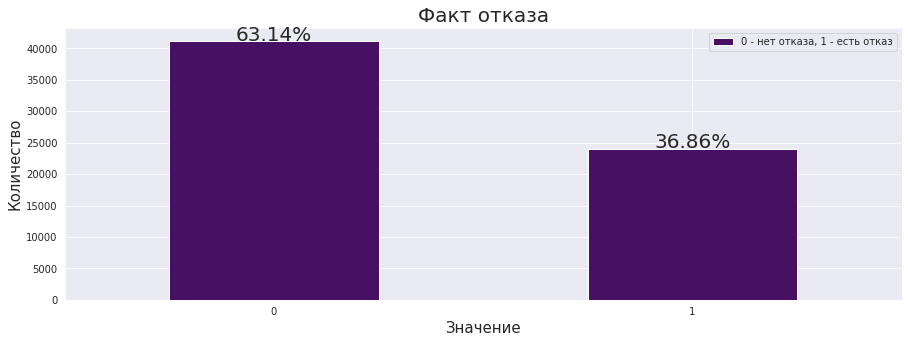

In [15]:
# Гистограмма на факт отказа
draw_hist(dt_train, column='is_canceled', figsize=(15,5), title='Факт отказа',
          percent_size=20, legend=['0 - нет отказа, 1 - есть отказ'])

Видим, что целевая переменная несбалансированная и имеет соотношение **63%** к **37%**.<br>
Почти **40%** отказов довольно большое значение от общей выборки. Это может говорить нам о сильных убытках.

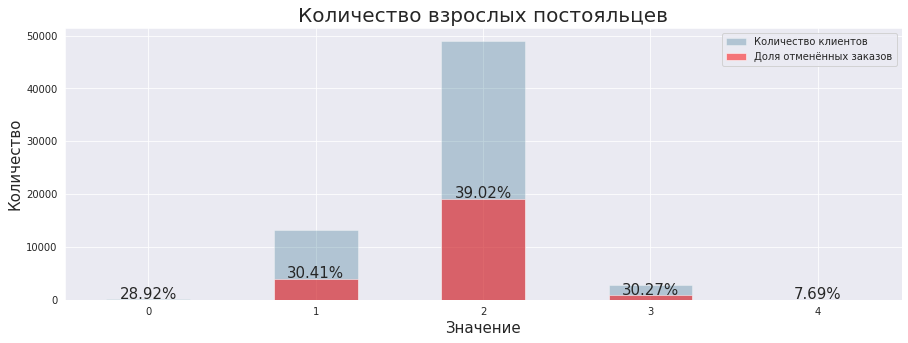

In [16]:
# График на количество взрослых постояльцев
draw_hist(dt_train, column='adults', target_column='is_canceled',
          title='Количество взрослых постояльцев', percent_size=15)

Тут мы видим, что чаще всего номера заказывают парами, но у них и самый высокий процент отказов – почти **40%**.<br>
Меньше всего заказов приходится на детей (где 0 взрослых) и компаний из четырех человек.

 Мы знаем, что по условию дети – это возраст от **3 до 14 лет**, то сдать им номер не могут. Получается, что номера, где 0 взрослых – это аномалии. Избавимся от них:

In [17]:
# Оставляем записи, где количество взрослых больше нуля
dt_train = dt_train[dt_train['adults'] > 0]
dt_test = dt_test[dt_test['adults'] > 0]

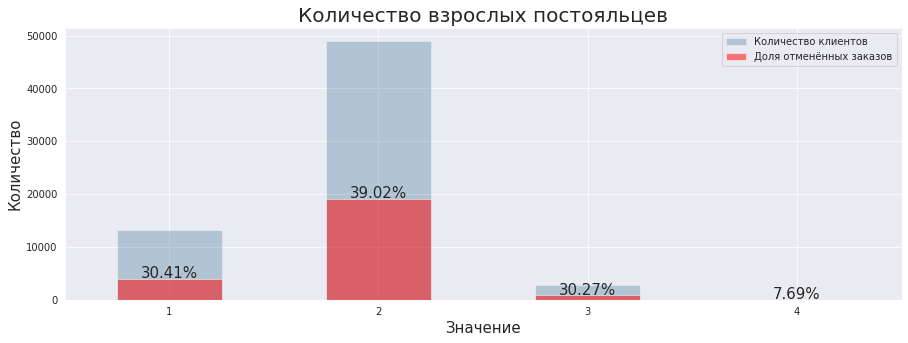

In [18]:
# Посмотрим на изменённый график
# График на количество взрослых постояльцев
draw_hist(dt_train, column='adults', target_column='is_canceled',
          title='Количество взрослых постояльцев', percent_size=15)

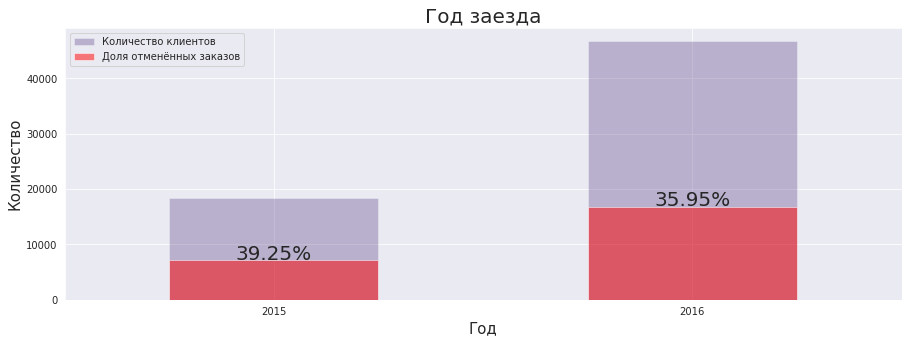

In [19]:
# График на год заезда
draw_hist(dt_train, column='arrival_date_year', target_column='is_canceled',
          title='Год заезда', xlabel='Год', percent_size=20)

В **2016** году клиентов было боле чем **в 2 раза больше** чем в **2015**, при этом процент отмененных заказов меньше – **34%**.<br>
Это лучше чем в **2015 - 40%**.

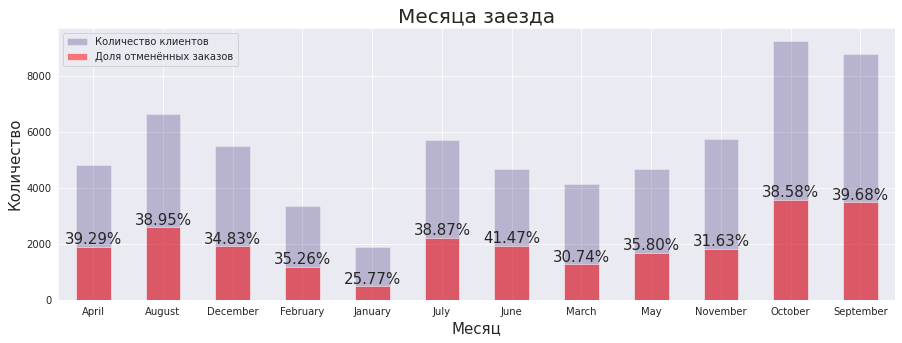

In [20]:
# График на месяца заезда
draw_hist(dt_train, column='arrival_date_month', target_column='is_canceled',
          title='Месяца заезда', xlabel='Месяц', percent_size=15)

Больше всего клиентов приходятся на **октябрь, сентябрь и август**. Возможно, это связано с тем, что в эти периоды люди часто берут отпуска.<br>
В среднем процент отменивших заказ варьируется от **30** до **40** процентов.

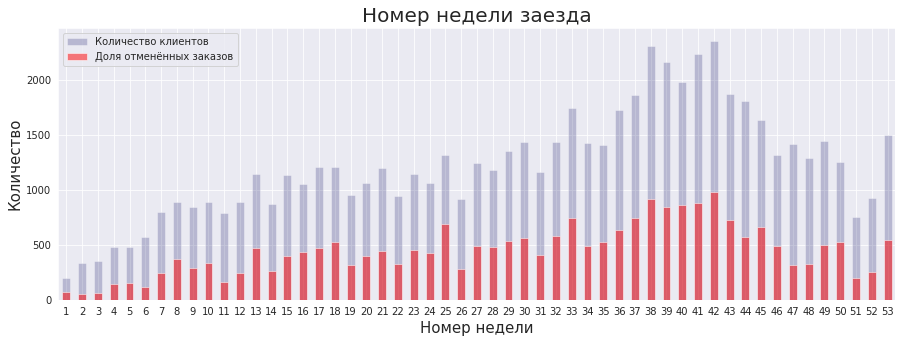

In [21]:
# График на неделю заезда
draw_hist(dt_train, column='arrival_date_week_number',target_column='is_canceled',
          title='Номер недели заезда', xlabel='Номер недели')

Аналогично графику по месяцам, видим, что график по неделям имеет весьма схожее распределение, только более подробное.

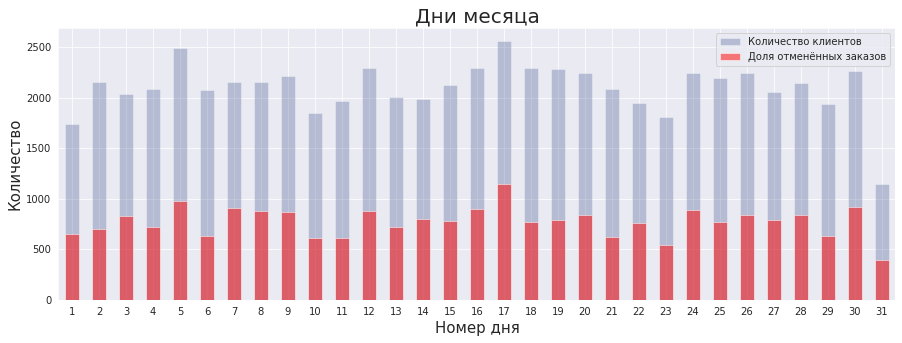

In [22]:
# График на день месяца
draw_hist(dt_train, column='arrival_date_day_of_month',target_column='is_canceled',
          title='Дни месяца', xlabel='Номер дня')

По этому графику сложно провести какую-то закономерность, но чаще всего клиенты поселяются в **5** и **17** числах, а реже всего в **31**.

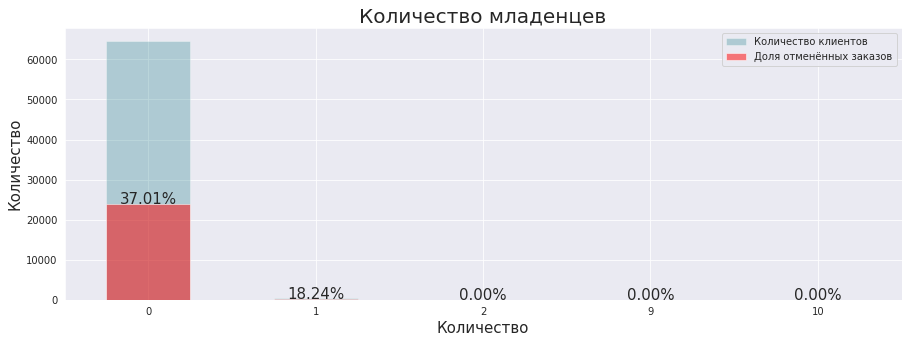

In [23]:
# График на количество младенцев
draw_hist(dt_train, column='babies',target_column='is_canceled',
          title='Количество младенцев', xlabel='Количество', percent_size=15)

In [24]:
# Выведем количество посетителей с младенцами
dt_train['babies'].value_counts().to_frame().T

,0,1,2,9,10
babies,64614,444,3,1,1


Клиенты без младенцев — это нормальная ситуация в этом отеле. Таких **64 777**, из них **37%** отказов.<br>
Тех, у кого есть **1 младенец**, всего **477** и они имеют чуть более низкий процент отказа - **18%**.<br>
Самые редкие гости с двумя или более младенцами. Их в общей сложности **5** и у всех **0%** отказов.<br>
Похоже, что чем больше детей привозят, тем менее вероятен факт отказа?<br>
Но вероятнее всего такой разброс из-за маленького числа наблюдений.

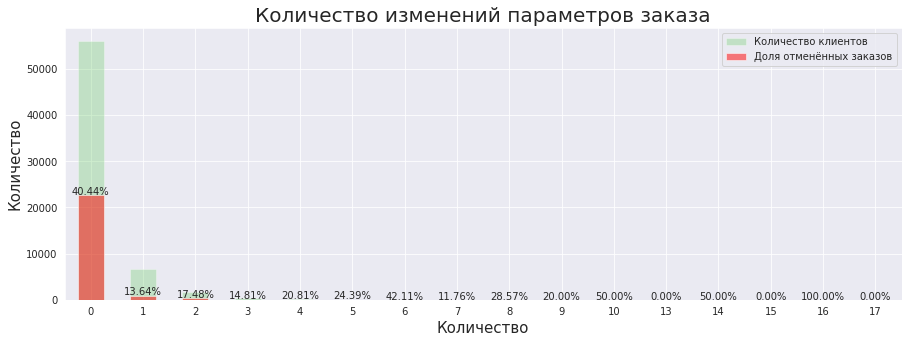

In [25]:
# График на количество изменений параметров заказа
draw_hist(dt_train, column='booking_changes',target_column='is_canceled',
          title='Количество изменений параметров заказа', xlabel='Количество', percent_size=10)

In [26]:
# Выведем количество изменений параметров заказа
dt_train['booking_changes'].value_counts().to_frame().T

,0,1,2,3,4,5,6,7,8,9,13,10,14,15,16,17
booking_changes,56078,6585,1745,405,149,41,19,17,7,5,4,2,2,2,1,1


График на количество изменений параметров заказа показал, что количество изменений может быть **от 0 до 17.**<br>
Большая часть клиентов не меняют исходный заказ их **56 195** и из них **40%** отказников.<br>
Намного меньше клиентов у которых есть хотя бы одно или два изменения- их в общей сумме **8 369**, а процент ушедших от **13% до 17%**<br>
Клиентов с большим количеством изменений **(от 3 до 17)** очень мало и процент отказа везде разный и для них нельзя вывести какую-то закономерность.


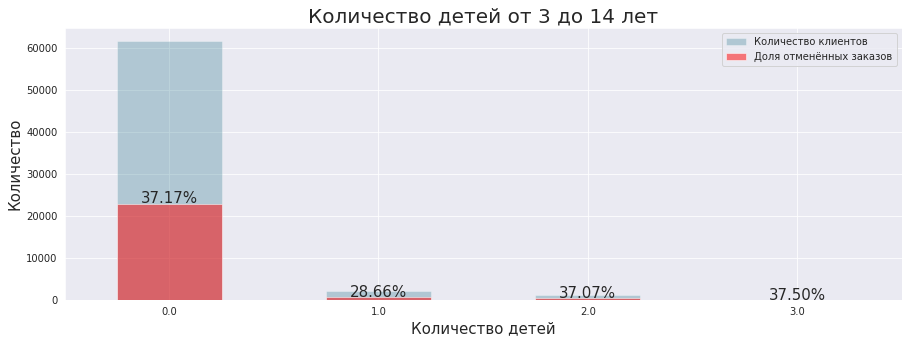

In [27]:
# График на количество детей
draw_hist(dt_train, column='children',target_column='is_canceled',
          title='Количество детей от 3 до 14 лет', xlabel='Количество детей', percent_size=15)

Картина как с младенцами – большинство заселяется в отель **без детей**. Тех у кого **1 или 2** ребенка – **мало**, а тех у кого **3 ребёнка** вообще **меньшинство**. Закономерности в отказах не выявлено.<br>
Проверим, могут ли быть ситуации, когда в заказе 0 взрослых, 0 детей и 0 младенцев

In [28]:
# Проверка на пустых клиентов
print('Пустые заказы:', len(dt_train.query('adults==0 and children==0 and babies==0')))

Пустые заказы: 0


Да, такие данные присутствуют. Скорее всего, тут какая-то ошибка, поэтому избавимся от этих строк в предобработке данных.<br>
А пока продолжим исследование.

In [29]:
print('Количество стран клиентов:', len(dt_train['country'].unique()))

Количество стран клиентов: 155


In [30]:
# Выведем топ 10 самых частых стран клиентов
dt_train['country'].value_counts().head(20).to_frame().T

,PRT,FRA,GBR,ESP,DEU,ITA,IRL,BEL,NLD,BRA,USA,CHE,AUT,SWE,POL,CHN,CN,ISR,RUS,NOR
country,28791,5958,5096,4887,3879,2319,1442,1231,1159,1083,1005,866,715,541,529,525,488,375,293,261


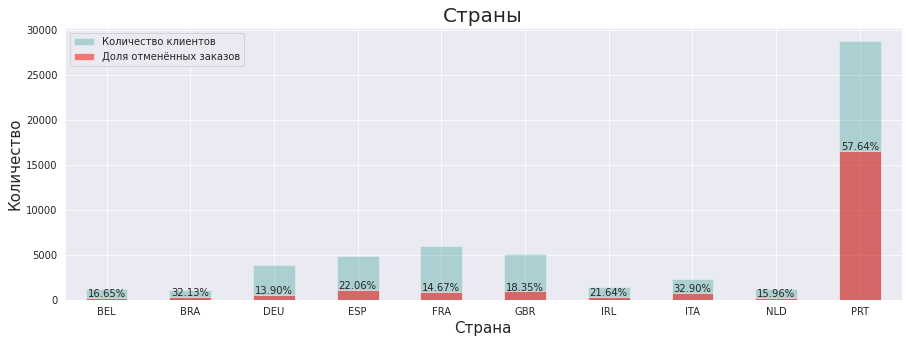

In [31]:
# # Для графика временно преобразуем тип категории в строку
# dt_train['country'] = dt_train['country'].astype('str')

# График на топ 10 стран
draw_hist(dt_train.loc[dt_train['country'].isin(dt_train['country'].value_counts().head(10).index)], column='country',target_column='is_canceled',
          title='Страны', xlabel='Страна', percent_size=10)

# # Преобразуем обратно в категорию
# dt_train['country'] = dt_train['country'].astype('category')

Больше всего клиентов из Португалии, при этом у них самый большой процент отказников – **57%**.<br>
По большому счету они и создают такую большую статистику отказов. У других стран процент варьируется от **13% до 33%**.

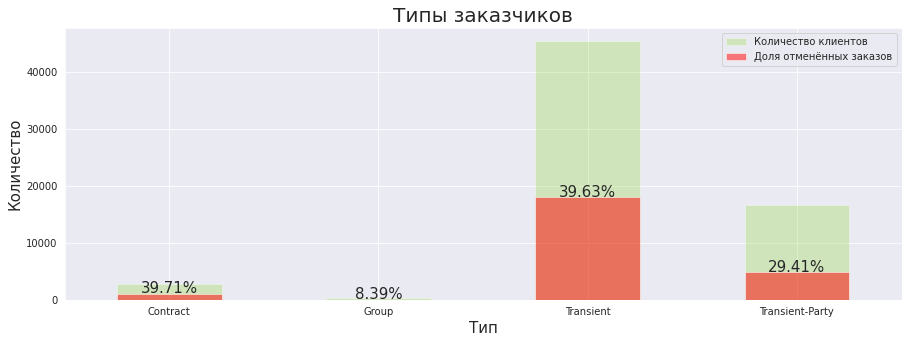

In [32]:
# График на тип заказчика
draw_hist(dt_train, column='customer_type',target_column='is_canceled',
          title='Типы заказчиков', xlabel='Тип', percent_size=15)

Посмотрим на значения категорий:
- **Contract** — договор с юридическим лицом;
- **Group** — групповой заезд;
- **Transient** — не связано с договором или групповым заездом;
- **Transient-party** — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

Тут сложно выделить какую-то взаимосвязь, но зато видим, что самый большой процент заказов с типом Transient.<br>
У него **405** отказников.

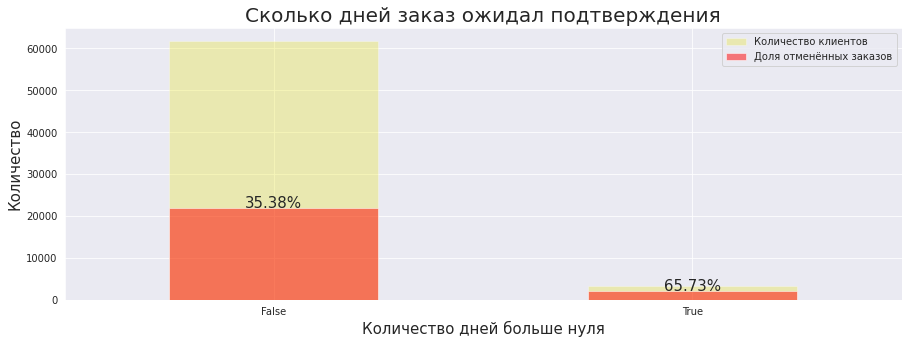

In [33]:
# Создаем временный столбец, в котором поместим сведение о 0 и более днях ожидания
dt_train['days_in_waiting_list_greater_zero'] = dt_train['days_in_waiting_list']>0

# График на ожидание заказа
draw_hist(dt_train, column='days_in_waiting_list_greater_zero', target_column='is_canceled',
          title='Cколько дней заказ ожидал подтверждения', xlabel='Количество дней больше нуля', percent_size=15)

# Удаляем временный столбец
dt_train = dt_train.drop(columns=['days_in_waiting_list_greater_zero'])

Отель работает довольно быстро. Об этом говорит количество дней подтверждения заказа.<br>
Те заказы, которые обрабатываются не в тот-же день имеют более высокий процент отказников – **65,73%** по сравнению с клиентами, заказ которых был обработан в тот-же день – **35%**

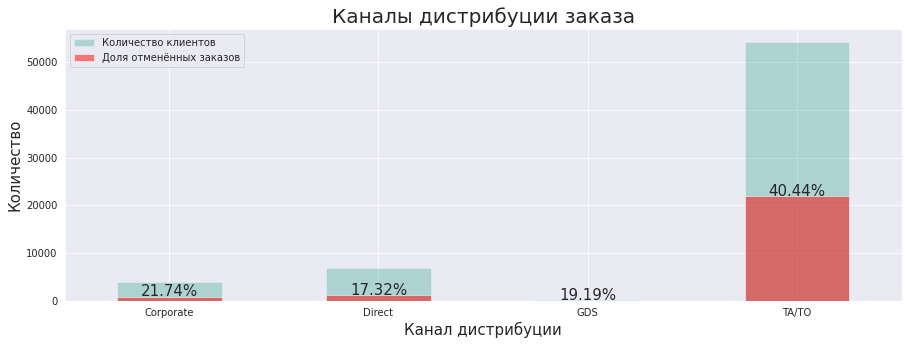

In [34]:
# График на каналы дистрибуции
draw_hist(dt_train, column='distribution_channel', target_column='is_canceled',
          title='Каналы дистрибуции заказа', xlabel='Канал дистрибуции', percent_size=15)

Самый популярный канал **TA/TO**. Он имеет **40%** отказов.<br>
Самый низкий процент отказов в **17%** у **Direct**, т.е. у людей которые забронировали отель лично.

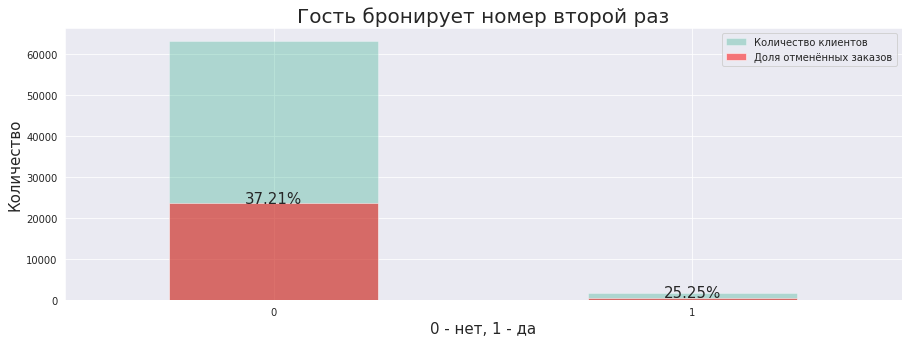

In [35]:
# График на признак, что гость бронирует номер второй раз
draw_hist(dt_train, column='is_repeated_guest', target_column='is_canceled',
          title='Гость бронирует номер второй раз', xlabel='0 - нет, 1 - да', percent_size=15)

Большая часть гостей посетили отель лишь единожды. Среди них **37%** отказников.<br>
Тех, кто посещает отель повторно намного меньше, процент ухода среди них **25%.**

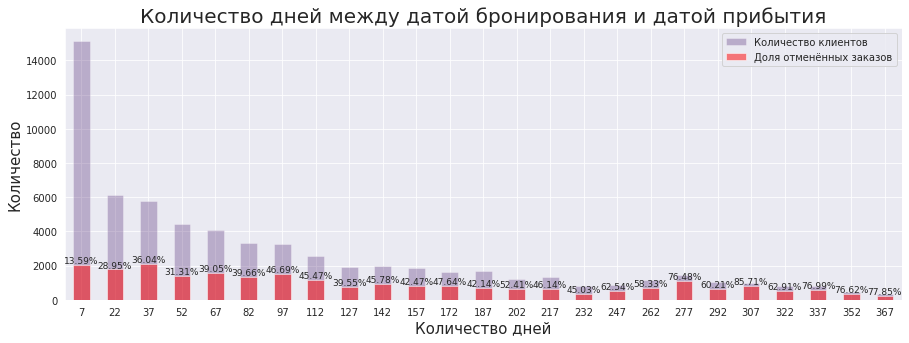

In [36]:
# График на количество дней между датой бронирования и датой прибытия
draw_hist(dt_train, column='lead_time', bins=25, target_column='is_canceled',
          title='Количество дней между датой бронирования и датой прибытия', xlabel='Количество дней', percent_size=9)

Большая часть клиентов бронирует отель в текущий день, либо за неделю.<br>
Можно заметить, что у клиентов, бронирующих номера в первые дни, меньше всего отказов - **13%**.<br>
Скорее всего это связано с тем, что они приходят в отель лично и тут-же получают номер.

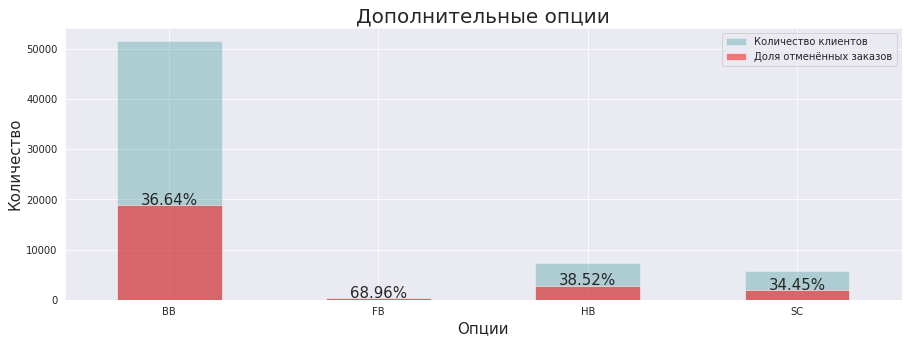

In [37]:
# График на дополнительные опции
draw_hist(dt_train, column='meal', target_column='is_canceled',
          title='Дополнительные опции', xlabel='Опции', percent_size=15)

Посмотрим на значения категорий:
- **SC** — нет дополнительных опций;
- **BB** — включён завтрак;
- **HB** — включён завтрак и обед;
- **FB** — включён завтрак, обед и ужин.

Больше всего клиентов предпочитают завтрак – отказов **36,6%**;<br>
Намного меньше клиентов, заказывают завтрак и обед – отказов **38,5%**;<br>
Примерно столько-же, вообще не заказывают ничего – отказов **34,4**%;<br>
И меньше всего клиентов заказывают все основные приемы пищи, при этом процент отказов самый высокий – **69%**.

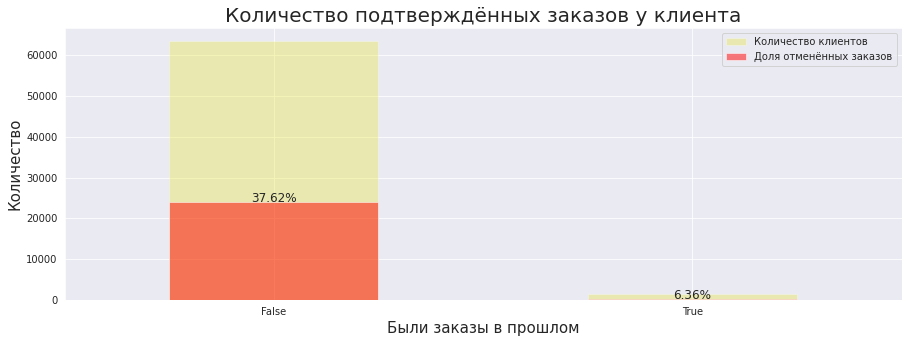

In [38]:
# Создаем временный столбец, в котором поместим сведение о 0 и более подтверждённых заказов
dt_train['previous_bookings_not_canceled_greater_zero'] = dt_train['previous_bookings_not_canceled']>0

# График на количество подтверждённых заказов у клиента
draw_hist(dt_train, column='previous_bookings_not_canceled_greater_zero', target_column='is_canceled',
          title='Количество подтверждённых заказов у клиента', xlabel='Были заказы в прошлом', percent_size=12)

# Удаляем временный столбец
dt_train = dt_train.drop(columns=['previous_bookings_not_canceled_greater_zero'])

Большая часть клиентов делает **заказ впервые**.<br>
Казалось-бы, что это мог бы быть очень мощный показатель для предсказания, но из-за малой численности клиентов, делающих заказ не в первый раз, сложно сказать есть ли какая-то зависимость, хотя процент отказов у них всего **6.35%**.

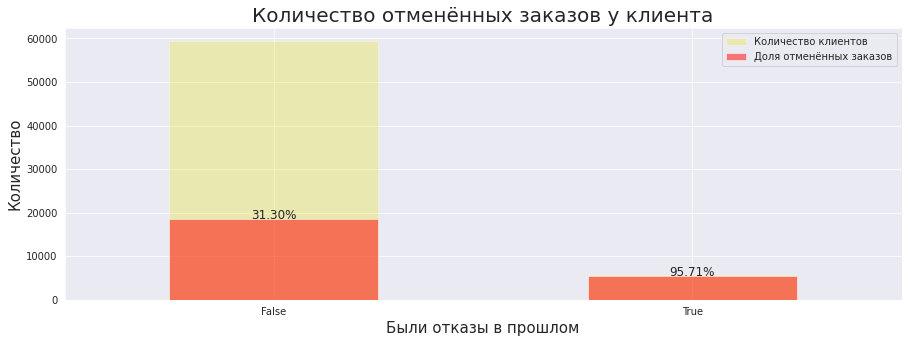

In [39]:
# Создаем временный столбец, в котором поместим сведение о 0 и более подтверждённых заказов
dt_train['previous_cancellations_greater_zero'] = dt_train['previous_cancellations']>0

# График на количество отменённых заказов у клиента
draw_hist(dt_train, column='previous_cancellations_greater_zero', target_column='is_canceled',
          title='Количество отменённых заказов у клиента', xlabel='Были отказы в прошлом', percent_size=12)

# Удаляем временный столбец
dt_train = dt_train.drop(columns=['previous_cancellations_greater_zero'])

А вот это, довольно мощный показатель. Клиенты, которые уже бронировали номер, но затем отменили, в **96%** случаях также отменят бронь.

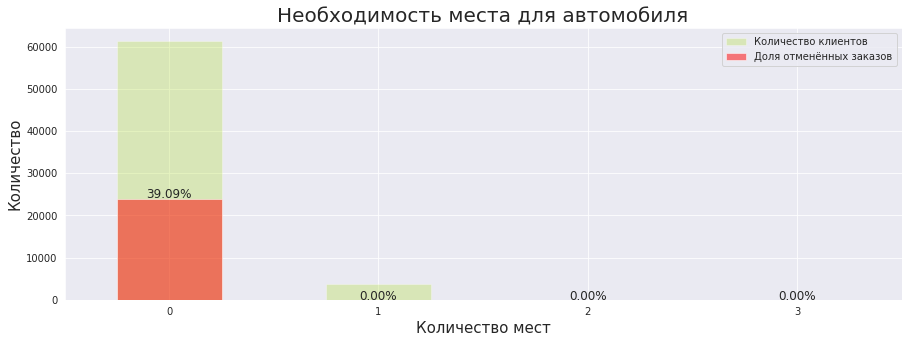

In [40]:
# График на необходимость места для автомобиля
draw_hist(dt_train, column='required_car_parking_spaces', target_column='is_canceled',
          title='Необходимость места для автомобиля', xlabel='Количество мест', percent_size=12)

In [41]:
# Выведем количество мест
dt_train['required_car_parking_spaces'].value_counts().to_frame().T

,0,1,2,3
required_car_parking_spaces,61383,3668,11,1


Большинству клиентов не нужно парковочное место для автомобиля.<br>
Однако те, у кого есть авто, обязательно осуществляют заказ. Хоть их в общей сложности всего **3 682**, процент отказа у них нулевой.

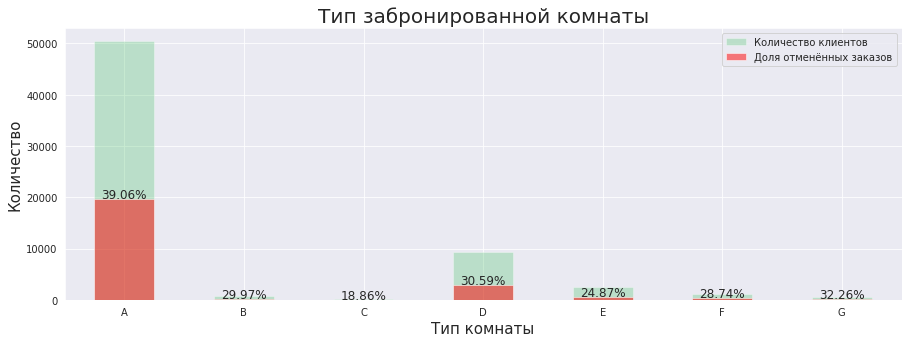

In [42]:
# График на тип забронированной комнаты
draw_hist(dt_train, column='reserved_room_type', target_column='is_canceled',
          title='Тип забронированной комнаты', xlabel='Тип комнаты', percent_size=12)

У нас есть следующие типы:
- категория **A:** за ночь — 1 000, разовое обслуживание — 400;
- категория **B:** за ночь — 800, разовое обслуживание — 350;
- категория **C:** за ночь — 600, разовое обслуживание — 350;
- категория **D:** за ночь — 550, разовое обслуживание — 150;
- категория **E:** за ночь — 500, разовое обслуживание — 150;
- категория **F:** за ночь — 450, разовое обслуживание — 150;
- категория **G:** за ночь — 350, разовое обслуживание — 150.

Чаще всего клиенты бронируют самый дорогой тип – **А**, что довольно удивительно.<br>
У него же и самый высокий процент отказников среди всех – **39%.**<br>
Остальные типы заказывают намного реже.

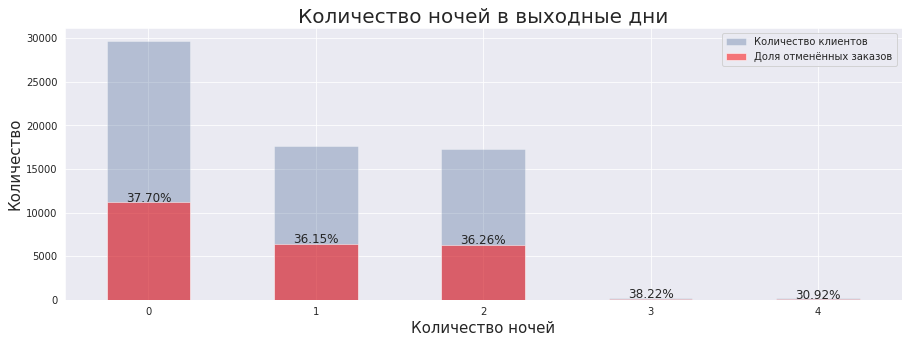

In [43]:
# График на количество ночей в выходные дни
draw_hist(dt_train, column='stays_in_weekend_nights', target_column='is_canceled',
          title='Количество ночей в выходные дни', xlabel='Количество ночей', percent_size=12)

Чаще берут номера на выходные дни. Несмотря на то, что на графике 0 ночей выглядит больше, ночи в выходные дни в совокупности дают больше. Процент отказов у всех довольно схожий.

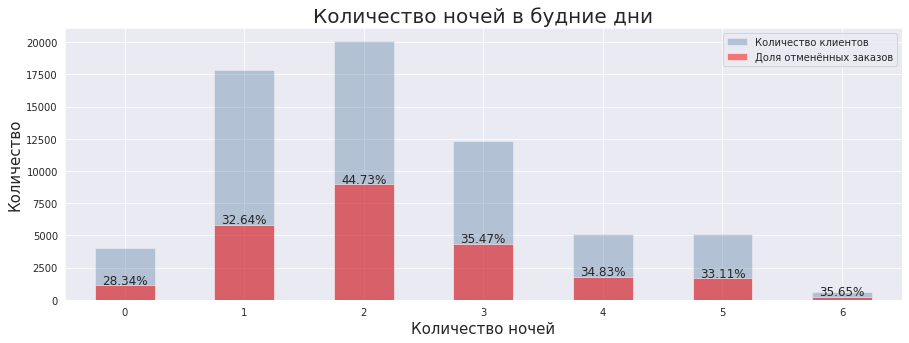

In [44]:
# График на количество ночей в будние дни
draw_hist(dt_train, column='stays_in_week_nights', target_column='is_canceled',
          title='Количество ночей в будние дни', xlabel='Количество ночей', percent_size=12)

В будни чаще других берут номера на **2 ночи**. Процент отказов **44.7%**.<br>
А у клиентов, которые берут номер на **1 ночь**, процент отказов один из самых низких – **32.6%**.

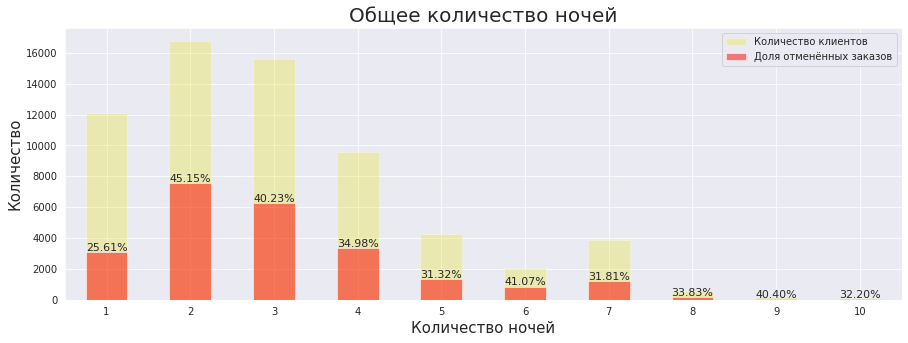

In [45]:
# График на общее количество ночей
draw_hist(dt_train, column='total_nights', target_column='is_canceled',
          title='Общее количество ночей', xlabel='Количество ночей', percent_size=11)

Тут видим, что чаще всего берут номера на **2 и 3** ночи, процент отказов также довольно большой – **45% и 40%**.<br>
В то время, на **3ем** месте по популярности находятся номера на **1 ночь**, при этом процент отказов там самый маленький – **25.6%**.

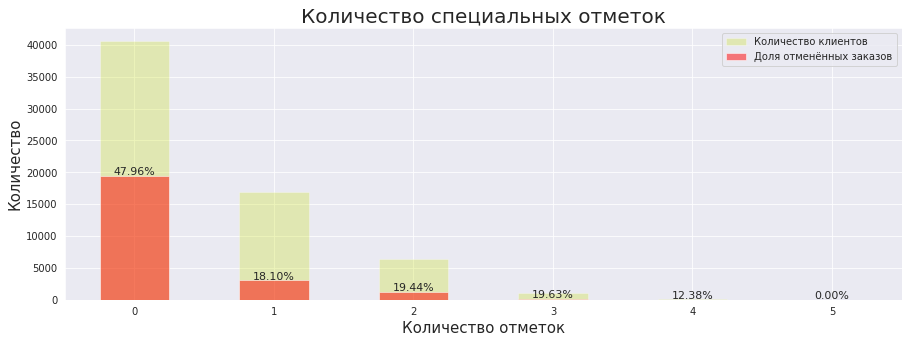

In [46]:
# График на количество специальных отметок
draw_hist(dt_train, column='total_of_special_requests', target_column='is_canceled',
          title='Количество специальных отметок', xlabel='Количество отметок', percent_size=11)

Не совсем понятно, что это за отметки, но у большинства их нет и процент отказов у них **48%**.<br>
У клиентов, у которых есть отметки, этот процент ниже **18%-19%**.

Теперь посмотрим на корреляцию параметров между собой:

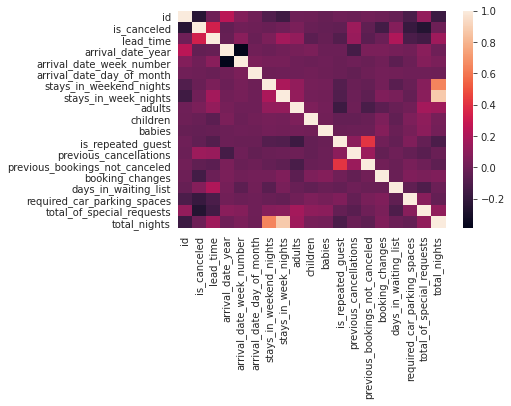

In [47]:
# Выводим тепловую карту по корреляции
sns.heatmap(dt_train.corr());

Сильная корреляция прослеживается у параметров, которые близки по смыслу:
- Признак того, что гость бронирует номер второй раз и количество подтверждённых заказов у клиента.
- Количество ночей в выходные дни, количество ночей в будние дни и общее количество ночей.
- Количество дней между датой бронирования и датой прибытия, и фактом отказа. Чем больше дней дем выше шанс отказа.

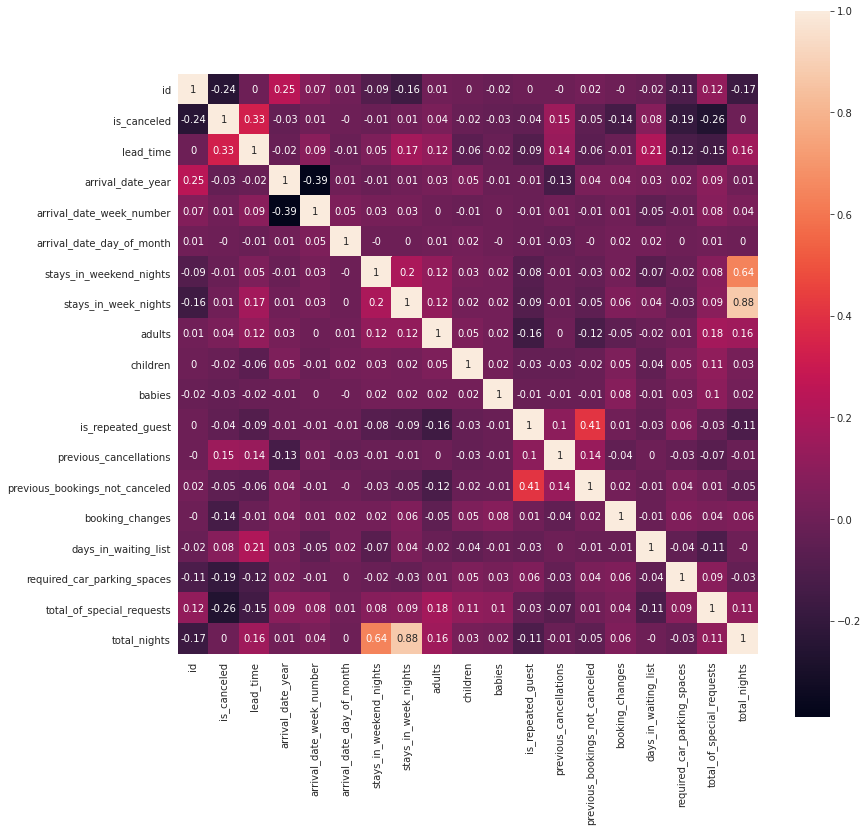

In [48]:
# Устанавливаем размер
plt.figure(figsize=(13, 13))
# Выводим тепловую карту по корреляции
sns.heatmap(dt_train.corr().round(2), annot=True, square=True);

##### Выводы исследовательского анализа

Все переменные были проанализированы в разрезе целевого показателя факта отказа.<br>
Были выявлены следующие факты:
- целевая переменная несбалансированная и имеет соотношение **63%** к **37%**;
- чаще всего номера заказывают **парами**;
- в **2016** году клиентов было боле чем **в 2 раза** больше чем в **2015**;
- больше всего заказов приходятся на **октябрь, сентябрь и август**;
- клиенты **с младенцами или детьми** – довольно **редкое явление** в этом отеле;
- клиенты, которые никак **не изменяют параметры** заказов большинство, но процент отказов у них - **40%**;
- больше всего клиентов из **Португалии**, но там же и самый большой процент отказов – **58%**;
- больше всего заказов – это частные лица (**Transient**);
- есть сильная закономерность: чем **больше дней** заказ **ожидает подтверждение**, тем вероятнее всего **от него откажутся**.
- чаще всего номера бронируют через **TA/TO**;
- большинство клиентов **бронируют** номер в отеле **в первый раз**. У них **37%** отказников;
- гости, которые **бронируют** номер **повторно**, отказываются реже – **25%**;
- чем **больше** дней **между датой бронирования и прибывания**, тем **больше шанс** что клиент **откажется**;
- чем **больше прибываний** у клиента в отеле, тем **больше шанс** что он **не откажется**. Процент отказа всего **6.35%**;
- гости, которые **совершали отказ ранее** – отказывают **повторно** в **95% случаев**;
- гости, у которых при себе **есть автомобиль** в исторических данных **никогда не отказывали**;
- чаще всего заказывают самые **дорогие номера категории A**, и также часто совершают **отказ – 40%**;
- номера чаще берут на **выходные дни**;
- чаще всего в номерах **задерживаются на 2-4 дня**;
- чем **больше специальных отметок** у клиента, тем **меньше процент ухода**.


На основе данных, полученных в результате анализа, опишем примерный портрет «**ненадёжного клиента**»:

- это пара, которая заказывает номер;
- они заселяются в сентябре в средних числах;
- они без детей;
- свой заказ никак не корректируют, сделали и забыли;
- они из Португалии;
- заказ совершают сами, в качестве дистрибьютора используют TA/TO;
- бронь делают за 3 месяца до прибытия;
- включают в опции завтрак и обед;
- до этого они делали бронь, но совершили отказ;
- без авто;
- бронируют дорогой номер типа А;
- номер на пару ночей в будние дни;
- специальных отметок не имеют.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Данные были проанализированы, теперь перед нами стоит задача разработать модель машинного обучения, которая на основе полученных признаков определять, является ли клиент ненадежным.<br>
Данное предсказание поможет в решении запросить у клиента депозит в размере **80%** от его заказа.<br>
Но для того, чтобы это все реализовать, нам нужно выписать все данные нашей задачи, а также разработать функцию по расчету прибыли.<br>
**Займемся этим на данном этапе.**

#### Объявление глобальных переменных

Создадим глобальные переменные, которые понадобятся нам для расчета прибыли:

In [49]:
# Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку
DEPOSIT_SIZE = 0.8

# Убираются каждые два дня
CLEANING_FREQ = 2

# Бюджет на разработку
BUDGET = 400_000

# Создадим датафрейм с ценой на типы номеров
ROOM_RATES = pd.DataFrame(columns=['services_cost', 'cleaning_cost'])
# --- Добавляем расценки для каждого номера
ROOM_RATES.loc['A'] = [1000, 400]
ROOM_RATES.loc['B'] = [800, 350]
ROOM_RATES.loc['C'] = [600, 350]
ROOM_RATES.loc['D'] = [550, 150]
ROOM_RATES.loc['E'] = [500, 150]
ROOM_RATES.loc['F'] = [450, 150]
ROOM_RATES.loc['G'] = [350, 150]

# Создаем датафрейм с сезонными коэффициентами
SEASONA_COEFF = pd.Series(name='season_coeff', dtype='float')
# --- весной цены повышаются на 20%
SEASONA_COEFF.loc['March'] = 1.2
SEASONA_COEFF.loc['April'] = 1.2
SEASONA_COEFF.loc['May'] = 1.2
# --- осенью - на 20%
SEASONA_COEFF.loc['September'] = 1.2
SEASONA_COEFF.loc['October'] = 1.2
SEASONA_COEFF.loc['November'] = 1.2
# --- летом — на 40%
SEASONA_COEFF.loc['June'] = 1.4
SEASONA_COEFF.loc['July'] = 1.4
SEASONA_COEFF.loc['August'] = 1.4

HOTEL_PROFIT = (lambda services_cost, cleaning_cost,
                    number_nights=1, season_coeff=0:
                        services_cost*(1+season_coeff)*number_nights - cleaning_cost*math.ceil(number_nights/CLEANING_FREQ))

LOSSES_IN_CANCEL = lambda services_cost, cleaning_cost: services_cost + cleaning_cost 

#### Разработка функции вычисления прибыли

Теперь нам необходимо разработать функцию для учета прибыли.<br>
Для этого мы должны учесть все правила, предоставленные в требовании заказчика.<br>
Посмотрим на них:
1. **Прибыль отеля** — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

Представим в виде формулы:<br>
**прибыль отеля** = **стоимостью номера (за все время)** - **затраты на обслуживание (за все время + подготовка номера)**

2. В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Получаем следующее:<br>
**стоимостью номера (за все время)** = **стоимостью номера (за ночь)** * **количество ночей**<br>

**затраты на обслуживание (за все время + подготовка номера)** = **стоимость уборки (за раз)** * ОкруглитьВниз(**количество ночей**/**частота обслуживания**) + **стоимость уборки (за раз)**

Для второй формулы стоит пояснить действия:<br>
Например, представим что клиент гостил 1 день с типом номера A, где уборка стоит 400.<br>
Получается, что мы подготавливаем номер – это 400 и больше ничего,<br>
т.к. убираются раз в 2 дня, а про уборку после выселения ничего не говорилось:<br>
**400**(стоимость) * ОкруглитьВниз(**1**(кол-во ночей), / **2**(частота обслуж)) + **400**(стоимость)<br>
400 * ОкруглитьВниз(1 / 2) + 400;<br>
400 * ОкруглитьВниз(0.5) + 400;<br>
400 * 0 + 400 = **400**<br>
т.е. за обслуживание мы должны заплатить 400, все сходится<br>
<br>
Теперь представим, что проживание длилось 5 дней в номере A.<br>
Подготовка номера – 400, обслуживание 2 раза * 400 , и того 1200:<br>
400 * ОкруглитьВниз(5 / 2) + 400;<br>
400 * ОкруглитьВниз(2.5) + 400;<br>
400 * 2 + 400 = **1200**.<br>
Тут формула тоже работает корректно.

3. В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%

Тут важно заметить еще следующий момент, если проживание клиента выпало на разные сезоны, то мы должны это учитывать.<br> Максимальное количество ночей, которые проводили клиенты – 10, но будем учитывать, что клиент может жить в отеле хоть целый год.<br>
Для этого нам нужно высчитать стоимость каждого дня.

функция **стоимостью номера(за день)**(Стоимость ночи, Месяц): Стоимость ночи * КоэффициентМесяца(Месяц)

**стоимостью номера (за все время)** = Σ{i=1}^количество дней: стоимостью номера (за день) * КоэффициентМесяца(Месяц(i))

4. Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

**Факт отмены** это **0 – если отмены нет** **1 – если есть**<br>
Немного модифицируем формулы, чтобы это учитывалось:

**затраты на обслуживание (за все время + подготовка номера)** = <br>
= стоимость уборки (за раз) * ОкруглитьВниз(количество ночей/частота обслуживания) * **(1 - факт отмены)**  + стоимость уборки (за раз)
<br>

**стоимостью номера (за все время)** =<br>
Σ{i=1}^количество дней ^ **(1 - факт отмены)**: стоимостью номера (за день)(стоимостью номера (за ночь), Месяц(i))
<br>

Проверим: пусть проживание бронировалось зимой (коэффициент не нужен) на 6 дней в номере A, но клиент сделал отказ (отказ = 1).<br>
**Подготовка номера** – 400, из за отказа последующие дни не считаем, и того 400 за обслуживание,<br>
**стоимостью одной ночи** - 1000, как заявлено в условии (цена за 1 ночь).<br>
Смотрим по формулам:<br>
400 * ОкруглитьВниз(5 / 2) * **(1 - 1)** + 400;<br>
400 * ОкруглитьВниз(2.5) * **0** + 400;<br>
**0** + 400 = **400**.<br>
Формула работает корректно.<br>

**стоимостью номера (за все время)** =<br>
Σ{i=1}^(6 ^ **(1 - 1)**): стоимостью номера (за день)(стоимостью номера (за ночь), Месяц(i));<br>
Σ{i=1}^(6 ^ **0**): стоимостью номера (за день)(стоимостью номера (за ночь), Месяц(i));<br>
Σ{i=1}^1: стоимостью номера (за день)(стоимостью номера (за ночь), Месяц(i));<br>
<br>
В данной формуле будет производиться всего одна итерация, поэтому расчет должен быть верным.
<br>
<br>
В итоге мы имеем следующие формулы для расчета прибыли:

1) **прибыль отеля** = стоимостью номера (за все время) - затраты на обслуживание (за все время + подготовка номера)<br>
2) **затраты на обслуживание (за все время + подготовка номера)** = стоимость уборки (за раз) * ОкруглитьВниз(количество ночей/частота обслуживания) * (1 - факт отмены)  + стоимость уборки (за раз)<br>
3) **стоимостью номера (за все время)** = Σ{i=1}^количество дней ^ (1 - факт отмены): стоимостью номера (за день) * КоэффициентМесяца(Месяц(i))

Напишем эти функции на python:

In [50]:
# Библиотека для работы с датами
import datetime
# Библиотека для работы с математикой
import math

In [51]:
# Функция расчета затрат на обслуживания
def get_cleaning_cost_all_night(row):
    '''
    Вычисляет стоимость цены уборки за все ночи и подготовку номера.
        Параметры:
            row (Series): строка датафрейма.
    '''
    # Возвращаем рассчитанную стоимость уборки за все ночи
    # Количество уборок вычисляется как общее количество ночей,
    # делёное на частоту и округленное вниз до целого
    # Факт отказа вычитаем из единицы, таким образом,
    # когда 0 – это отказ, на него умножаются дни, т.е. уборки не было, и 1 - когда пользователь посетил отель.
    # Прибавляем одну уборку, как подготовку комнаты.
    return row['cleaning_cost'] * math.floor(row['total_nights']/CLEANING_FREQ)*(1-row['is_canceled']) + row['cleaning_cost']


# Функция для вычисления стоимости номера за одну ночь
def get_room_cost_one_night(services_cost, season_coeff):
    '''
    Вычисляет стоимость за одну ночь с учетом коэффициента.
    Просто перемножает два значения, при этом осуществляет проверку на NaN и None значение.
        Параметры:
            services_cost (float): стоимость номера за 1 ночь.
            season_coeff (float): сезонный коэффициент.
    '''
    # Проверяем, является ли коэффициент NaN или None значением
    if season_coeff == None:
        # Коэффициент отсутствует
        season_coeff = 1
    elif math.isnan(season_coeff):
        # Коэффициент отсутствует
        season_coeff = 1
    # Умножаем стоимость на коэффициент, при этом делаем проверку на NaN
    return services_cost*season_coeff


# Функция для вычисления стоимости номера за все ночи
def get_room_cost_all_night(row):
    '''
    Вычисляет стоимость цены номера за все ночи.
    Считает стоимость каждого дня в соответствии с сезонным коэффициентом.
         Параметры:
                row (Series): строка датафрейма.
    '''
    # Проверяем на отменный заказ
    if row['is_canceled']:
        # Возвращаем стоимость убытка за одну ночь
        return get_room_cost_one_night(row['services_cost'], row['season_coeff']) * -1
    
    # Переменная для накопления суммы
    total_cost = 0
    # Переменная для текущей даты
    current_date = row['start_date']
    
    # Обходим такое число раз, сколько клиент был ночей
    for i in range(row['total_nights']):
        # Получаем сезонный коэффициент из глобальной переменной
        season_coeff = SEASONA_COEFF.get(current_date.strftime("%B"))
        # Прибавляем цену за ночь к общей сумме
        total_cost += get_room_cost_one_night(row['services_cost'], season_coeff)
        # Прибавляем к дате день
        current_date += datetime.timedelta(days=1)
    # Возвращаем полную стоимость    
    return total_cost


# Функция для вычисления депозита
def get_deposit(row):
    '''
    Вычисляет размер депозита.
    Берет стоимость за одну ночь и стоимость за уборку.
    Суммирует и находит процент от них.
        Параметры:
            row (Series): строка датафрейма.
    '''
    # Возвращаем полную стоимость   
    return (get_room_cost_one_night(row['services_cost'], row['season_coeff']) + row['cleaning_cost'])*DEPOSIT_SIZE 

In [52]:
# Функция для расчета прибыли отеля
def get_profit(data, include_deposit=False):
    '''
    Функция для расчета прибыли для фрейма данных.
    Возвращает датафрейм с рассчитанными параметрами.
        Параметры:
            data (DataFrame): источник данных для вычисления прибыли.
    '''
    # Подготовка данных для расчета
    # --- Присоединяем цену за сервис, цену за уборку и сезонный коэффициент
    data = (data.merge(ROOM_RATES, left_on='reserved_room_type', how='left', right_index=True)
        .merge(SEASONA_COEFF, left_on='arrival_date_month', how='left', right_index=True).copy())
    
    # --- Конвертируем название месяца в число
    data['arrival_date_month_num'] = pd.to_datetime(data['arrival_date_month'], format='%B').dt.month

    # --- Создаем столбце с датой первого дня прибывания
    data['start_date'] = data.apply(lambda row: datetime.datetime(row['arrival_date_year'],
                                                                row['arrival_date_month_num'],
                                                                row['arrival_date_day_of_month']), axis=1)
    # Производим расчеты
    # --- Получаем стоимость номера за все ночи
    data['room_cost_all_night'] = data.apply(get_room_cost_all_night, axis=1)
    
    # --- Получаем стоимость обслуживания номера
    data['cleaning_cost_all_night'] = data.apply(get_cleaning_cost_all_night, axis=1)
    
    # --- Получаем прибыль
    data['profit'] = data['room_cost_all_night'] - data['cleaning_cost_all_night']
    
    # --- Получаем депозит
    data['deposit'] = data.apply(get_deposit, axis=1)    
    
    # Возвращаем фрейм данных с рассчитанными полями
    return data

Функции были разработаны, Убедимся что они работают корректно:

#####  Тестирование функций

In [53]:
# Выполним все расчеты и сохраним в отдельную переменную
dt_train_with_calc_profit = get_profit(dt_train)

In [54]:
# Проверим, есть ли пустые значения в столбце прибыли
print('Количество неопределённой прибыли:', dt_train_with_calc_profit['profit'].isna().sum())
# в столбце депозита
print('Количество неопределённых депозитов:', dt_train_with_calc_profit['deposit'].isna().sum())

Количество неопределённой прибыли: 0
Количество неопределённых депозитов: 0


Пропусков не обнаружено. Теперь нам следует детально рассмотреть несколько примеров расчета прибыли:

In [55]:
# Чтобы не перегружать вывод лишними полями, оставим только те, которые учувствуют в расчетах
columns_to_check = ['arrival_date_day_of_month','arrival_date_month',
                   'arrival_date_year','start_date','total_nights',
                   'is_canceled','reserved_room_type','services_cost',
                   'season_coeff','cleaning_cost',
                   'room_cost_all_night','cleaning_cost_all_night',
                   'profit','deposit']

In [56]:
# Выведем значения полей одной произвольной записи
dt_train_with_calc_profit.sample(1, random_state=777)[columns_to_check].iloc[0]

arrival_date_day_of_month                      3
arrival_date_month                       October
arrival_date_year                           2016
start_date                   2016-10-03 00:00:00
total_nights                                   2
is_canceled                                    1
reserved_room_type                             A
services_cost                               1000
season_coeff                                 1.2
cleaning_cost                                400
room_cost_all_night                      -1200.0
cleaning_cost_all_night                      400
profit                                   -1600.0
deposit                                   1280.0
Name: 33275, dtype: object

Итак, мы получили произвольную запись, попробуем выполнить расчет вручную и оценим правильность нашей функции:

- Дата заселения: **15 сентября 2016** года.
- Количество ночей: **1**.
- Отмена: **нет**.
- Тип комнаты: **А** (цена за ночь: 1000, цена за уборку: 400).
- Сезонный коэффициент: **осенний, 20%**.

Считаем:
1. Подготовка номера - **400**.
2. Уборка раз в 2 дня: не производилось, т.к. всего 1 день.
3. Цена за проживание с коэффициентом по количеству дней – 1000 + 20% * 1 = **1200**.
4. Прибыль: 1200 - 400 = **800**
5. Депозит: (400 + 1200) * 0.8 = **1 280**

Все сходится. Пробуем еще:

In [57]:
# Выведем значения полей одной произвольной записи
dt_train_with_calc_profit.sample(1, random_state=123654)[columns_to_check].iloc[0]

arrival_date_day_of_month                     30
arrival_date_month                     September
arrival_date_year                           2016
start_date                   2016-09-30 00:00:00
total_nights                                   3
is_canceled                                    0
reserved_room_type                             A
services_cost                               1000
season_coeff                                 1.2
cleaning_cost                                400
room_cost_all_night                       3600.0
cleaning_cost_all_night                      800
profit                                    2800.0
deposit                                   1280.0
Name: 60342, dtype: object

Данные:
- Дата заселения: **18 апреля 2016** года.
- Количество ночей: **5**.
- Отмена: **нет**.
- Тип комнаты: **D** (цена за ночь: 550, цена за уборку: 150).
- Сезонный коэффициент: **весенний, 20%**.

Считаем:
1. Уборка раз в 2 дня: 5 дней, значит уборка была 2 раза: 2 * 150 = **300** + подготовка номера **150** итого **450**.
2. Цена за проживание с коэффициентом по количеству дней: (550 + 20%) * 5 = **3 300**.
3. Прибыль: 3300 - 450 = **2 850**
4. Депозит: (150 + 660) * 0.8 = **648**

Тут тоже все ок, поострим еще пару примеров:

In [58]:
# Выведем значения полей одной произвольной записи
dt_train_with_calc_profit.sample(1, random_state=2007)[columns_to_check].iloc[0]

arrival_date_day_of_month                     21
arrival_date_month                     September
arrival_date_year                           2016
start_date                   2016-09-21 00:00:00
total_nights                                   3
is_canceled                                    0
reserved_room_type                             A
services_cost                               1000
season_coeff                                 1.2
cleaning_cost                                400
room_cost_all_night                       3600.0
cleaning_cost_all_night                      800
profit                                    2800.0
deposit                                   1280.0
Name: 59725, dtype: object

Данные:
- Дата заселения: **7 сентября 2016** года.
- Количество ночей: **4**.
- Отмена: **Да**.
- Тип комнаты: **F** (цена за ночь: 450, цена за уборку: 150).
- Сезонный коэффициент: **осенний, 20%**.

Считаем:
1. Уборкок не было, т.к. номер отменен, только подготовка номера: **150**.
2. Из-за отмены у нас убыток в виде одной ночи: (450 + 20%) * -1 = **-540**.
3. Прибыль: -540 - 150 = **-690**
4. Депозит: (150 + 540) * 0.8 = **552**

Сходится. Рассмотрим последний случай, когда часть дней приходится на сезонный коэффициент, а другая нет:

In [59]:
# Формируем запрос на выборку определённых данный с пересечением коэффициентов
(dt_train_with_calc_profit
 .query('arrival_date_month=="November" and arrival_date_day_of_month>28 and total_nights>4 and is_canceled==0')
 .sample(1, random_state=1999).iloc[0][columns_to_check])

arrival_date_day_of_month                     29
arrival_date_month                      November
arrival_date_year                           2016
start_date                   2016-11-29 00:00:00
total_nights                                   5
is_canceled                                    0
reserved_room_type                             A
services_cost                               1000
season_coeff                                 1.2
cleaning_cost                                400
room_cost_all_night                       5400.0
cleaning_cost_all_night                     1200
profit                                    4200.0
deposit                                   1280.0
Name: 64011, dtype: object

Данные:
- Дата заселения: **29 ноября 2016** года.
- Количество ночей: **5**.
- Отмена: **нет**.
- Тип комнаты: **A** (цена за ночь: 1000, цена за уборку: 400).
- Сезонный коэффициент: 2 дня **осенний, 20%** и 3 дня без коэффициента.

Считаем:
1. Проживание длилось 5 дней - значит было 2 уборки и подготовка номера: 400 * 2 + 400 = **1 200**.
2. Проживание длилось 5 дней, из которых 2 с сезонным коэффициентом в 20% <br>
    и 3 дня без коэффициента, т.к. следующий зимний месяц декабрь: (1000 + 20%) * 2 + 1000 * 3 = **5 400**.
3. Прибыль: 5 400 - 1 200 = **4 200**
4. Депозит: (1200 + 400) * 0.8 = **1 280**

И тут все в точку. Функции расчета работают корректно.

#### Оценка прибыли отеля без внедрения депозитов

Посмотрим, как какую суммарную прибыль нам принесут тестовые данные:

In [60]:
# Выполним все расчеты и сохраним в отдельную переменную
dt_test_with_calc_profit = get_profit(dt_test)

In [61]:
# Посмотрим на случайные расчитанные данные
dt_test_with_calc_profit.sample(3, random_state=15)[columns_to_check]

,arrival_date_day_of_month,arrival_date_month,arrival_date_year,start_date,total_nights,is_canceled,reserved_room_type,services_cost,season_coeff,cleaning_cost,room_cost_all_night,cleaning_cost_all_night,profit,deposit
27894,12,June,2017,2017-06-12,2,0,D,550,1.4,150,1540.0,300,1240.0,736.0
12683,4,May,2017,2017-05-04,2,1,A,1000,1.2,400,-1200.0,400,-1600.0,1280.0
590,27,March,2017,2017-03-27,2,1,E,500,1.2,150,-600.0,150,-750.0,600.0


In [62]:
# Посмотрим на процент отказников
print('Процент отказов:', dt_test_with_calc_profit['is_canceled'].mean())

Процент отказов: 0.38833750734316547


Процент отказников +- такой же, как и на обучающей выборке.<br>
Попробуем рассчитать сумму прибыли для всей таблицы:

In [63]:
# Находим сумму всей прибыли
print('Сумма всей прибыли:', dt_test_with_calc_profit['profit'].sum())

Сумма всей прибыли: 32556440.0


**32 629 090** – запомним эту сумму. Сравним её потом с результатами машинного обучения.<br>
Сейчас посмотрим, какая у нас сумму убытка:

In [64]:
# Находим сумму всех убытков
print('Сумма всех убытков:', dt_test_with_calc_profit.query('is_canceled==1')['profit'].sum())

Сумма всех убытков: -18000470.0


In [65]:
# Находим сумму всех убытков
print('Сумма всех полученных средств:', dt_test_with_calc_profit.query('is_canceled==0')['profit'].sum())

Сумма всех полученных средств: 50556910.0


На данный момент мы получаем **50 миллионов**, но теряем **18 миллионов**.<br>
Из-за чего суммарно у нас получается **32 миллиона**. Теряем **36%** прибыли.<br>
Довольно большой убыток, с которым нужно что-то делать.<br>
Посмотрим, какую прибыль принесет нам идеальная модель, которая определяет всех отказников и берет у них депозит:

In [66]:
print('Прибыль с депозитов:',dt_test_with_calc_profit.query('is_canceled==1')['deposit'].sum())

Прибыль с депозитов: 14400376.0


In [67]:
# Суммируем прибыль где клиенты не отказались от заказа с депозитами отказников
print('Прибыль идеальной модели:',
     dt_test_with_calc_profit.query('is_canceled==0')['profit'].sum()
     + dt_test_with_calc_profit.query('is_canceled==1')['deposit'].sum())

Прибыль идеальной модели: 64957286.0


In [68]:
# Суммируем прибыль где клиенты не отказались от заказа с депозитами отказников
print('Прибыль идеальной модели:',
     dt_test_with_calc_profit['profit'].sum()
     + dt_test_with_calc_profit.query('is_canceled==1')['deposit'].sum())

Прибыль идеальной модели: 46956816.0


Если бы мы брали у всех отказников депозит, то заработали бы **14 миллионов**.<br>
Итоговая прибыль у нас получилась бы такая: **46 956 816**.<br>
Это увеличение прибыли в целых **40%** от текущей.<br>

Можно, конечно бы было добиться этого и без модели, если бы мы ввели обязательную предоплату,<br>
но тогда, вероятно, был бы отток клиентов, а это не наш метод.<br>

Будем производить **тонкую работу** с теми, кто скорее всего сделает отказ.

### Шаг 4. Разработка модели ML

Вот мы и перешли к этапу разработки модели машинного обучения. Прежде чем приступить к нему, подготовим данные.

#### Подготовка данных для ML

In [69]:
# Удалим столбце ID, который не понадобится нам в обучении модели,
# Сохраним данные в отдельной переменной
dt_train_X = dt_train.drop(['id', 'is_canceled'], axis=1).copy()
dt_test_X = dt_test.drop(['id', 'is_canceled'], axis=1).copy()
# Сохраним правильные ответы
dt_train_y = dt_train['is_canceled']
dt_test_y = dt_test['is_canceled']

Также, в таблицах есть значения, которых очень мало, например количество мест для автомобиля.<br>
Подавляющее число не заказывает парковочные места, а тех, кому нужно 2 или 3 вообще единицы. Такие переменные мы сделаем бинарными: 1 – есть авто, 0 – нет.<br>
Вот список таких переменных, которые мы так преобразуем:
- babies -> has_babies
- booking_changes -> has_booking
- children -> has_children
- days_in_waiting_list -> days_waiting_great_zero
- previous_bookings_not_canceled -> has_confirmed
- previous_cancellations -> has_cancellations
- required_car_parking_spaces -> has_car

In [70]:
# Наличие детей
dt_train_X['has_babies'] = (dt_train['babies']>0)*1
dt_test_X['has_babies'] = (dt_test['babies']>0)*1

# Наличие изменений в заказе
dt_train_X['has_changes'] = (dt_train['booking_changes']>0)*1
dt_test_X['has_changes'] = (dt_test['booking_changes']>0)*1

# Наличие изменений в заказе
dt_train_X['has_children'] = (dt_train['children']>0)*1
dt_test_X['has_children'] = (dt_test['children']>0)*1

# Ожидание больше дня
dt_train_X['days_waiting_great_zero'] = (dt_train['days_in_waiting_list']>0)*1
dt_test_X['days_waiting_great_zero'] = (dt_test['days_in_waiting_list']>0)*1

# Наличие подтверденных заказов
dt_train_X['has_confirmed'] = (dt_train['previous_bookings_not_canceled']>0)*1
dt_test_X['has_confirmed'] = (dt_test['previous_bookings_not_canceled']>0)*1

# Наличие отказов
dt_train_X['has_cancellations'] = (dt_train['previous_cancellations']>0)*1
dt_test_X['has_cancellations'] = (dt_test['previous_cancellations']>0)*1

# Наличие авто
dt_train_X['has_car'] = (dt_train['required_car_parking_spaces']>0)*1
dt_test_X['has_car'] = (dt_test['required_car_parking_spaces']>0)*1

# Удаляем лишние столбцы
dt_train_X = dt_train_X.drop(['babies', 'booking_changes','children','days_in_waiting_list','previous_bookings_not_canceled',
                                    'previous_cancellations','required_car_parking_spaces'], axis=1)
dt_test_X = dt_test_X.drop(['babies', 'booking_changes','children','days_in_waiting_list','previous_bookings_not_canceled',
                                  'previous_cancellations','required_car_parking_spaces'], axis=1)

Также, мы можем избавиться от столбцов **года** и **месяца** и **общее количество ночей**.<br>
Если посудить, то система будет использоваться в реальном времени и не может возникнуть ситуация, когда клиент закажет номер из прошлого.
Месяца нам не нужны по той причине, что у нас есть показатель недели года – он более подробный.<br>
Общее количество дней можно посчитать количество дней в будни и в выходные.

In [71]:
# Удаляем лишние столбцы
dt_train_X = dt_train_X.drop(['arrival_date_year', 'arrival_date_month'], axis=1)
dt_test_X = dt_test_X.drop(['arrival_date_year', 'arrival_date_month'], axis=1)

In [72]:
# Проверяем данные
print('(обучающая) Всего записей:', len(dt_train_X))
print('(обучающая) Тех записей, где общее количество ночей равно сумме ночей по будням и по выходным:', 
      (dt_train_X['total_nights'] == dt_train_X['stays_in_week_nights']+dt_train_X['stays_in_weekend_nights']).sum())

print('(тестовая) Всего записей:', len(dt_test_X))
print('(тестовая) Тех записей, где общее количество ночей равно сумме ночей по будням и по выходным:', 
      (dt_test_X['total_nights'] == dt_test_X['stays_in_week_nights']+dt_test_X['stays_in_weekend_nights']).sum())

(обучающая) Всего записей: 65063
(обучающая) Тех записей, где общее количество ночей равно сумме ночей по будням и по выходным: 65063
(тестовая) Всего записей: 32343
(тестовая) Тех записей, где общее количество ночей равно сумме ночей по будням и по выходным: 32343


Все сходится, значит столбец total_nights можно удалить:

In [73]:
# Удаляем лишние столбцы
dt_train_X = dt_train_X.drop(['total_nights'], axis=1)
dt_test_X = dt_test_X.drop(['total_nights'], axis=1)

Теперь нам нужно преобразовать категориальные переменные в числовые.<br>
Такие переменные как **meal, distribution_channel, reserved_room_type, customer_type, country**.

In [74]:
# Для масштабирования признаков
from sklearn.preprocessing import StandardScaler
# Для преобразования столбцов
from sklearn.compose import ColumnTransformer
# Используем конвейер для преобразования всех данных
from sklearn.pipeline import Pipeline
# Для категориальных признаков
from sklearn.preprocessing import OneHotEncoder

In [75]:
# Определяем список категориальных значений
categorical_features = dt_train_X.select_dtypes(include='object').columns
# Создаем объект кодирования
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Определяем порядковые переменные
numerical_features = dt_train_X._get_numeric_data().columns
# Создаем объект для масштабирования
numerical_transformer = StandardScaler()

# Используем трансформатор столбцов, определяем трансформируемые параметры
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Создаем конвеер для преобразования за один раз
model_transform = Pipeline(steps=[('preprocessor', preprocessor)])

# Трансформируем обучающую и тестовую выборку
dt_train_X = model_transform.fit_transform(dt_train_X)
dt_test_X = model_transform.transform(dt_test_X)

Данные подготовили. Прежде чем приступим к моделям, сделаем фрейм данных, в котором будем хранить результаты моделей для дальнейшего сравнения:

In [76]:
# Импортируем функции для расчета метрик
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, confusion_matrix)

In [77]:
# Создаем таблицу для хранения показателей моделей
models_characteristics = pd.DataFrame(columns=['model', 'F1', 'precision','recall', 'accuracy', 
                                               'roc_auc'])
models_characteristics['model'] = models_characteristics['model'].astype('object')

In [78]:
def fix_result_model(model, X, y, title, original_data, show_metrics=True):
    '''
    Сохраняет результат в таблицу, а также выводит графики и основные показатели.
        Параметры:
            model (model): Модель ML.
            X (DataFrame): признаки объектов.
            y (Series): целевой признак.
            title (str): заголовок.
            original_data (DataFrame): исходный датафрейм (который не трансформирован).
            show_metrics (bool): отобрать или нет графики.
    '''
    # Предсказываем вероятность классов и выводим график
    pred_prob_one = model.predict_proba(X)[:, 1]
    # Предсказываем значения классов
    prededict = model.predict(X)
    
    # Вычисляем все метрики
    f1 = f1_score(y, prededict)
    precision = precision_score(y, prededict)
    recall = recall_score(y, prededict)
    accuracy = accuracy_score(y, prededict)
    roc_auc = roc_auc_score(y, pred_prob_one)
    
    # Вычисляем метрики бизнеса
    orig_data = original_data.copy()
    # Обозначаем исходный столбце
    orig_data = orig_data.rename(columns={'is_canceled': 'is_canceled_true'})
    # Сохраняем предсказания в текущий столбец            
    orig_data['is_canceled'] = prededict
    # Рассчитываем прибыль
    calculated_profit = get_profit(orig_data)
    # Вычисляем общую прибыль
    profit = (calculated_profit.query('is_canceled==0')['profit'].sum()
          + calculated_profit.query('is_canceled==1')['deposit'].sum()
          - calculated_profit.query('is_canceled_true==1 and is_canceled==0')['deposit'].sum())
    
    # Вычитываем сумму депозитов
    profit_deposits = calculated_profit.query('is_canceled==1')['deposit'].sum()
    # Записываем данные в таблицу регистрации
    models_characteristics.loc[title] = [model, f1, precision, recall, accuracy, roc_auc, profit, profit_deposits]
    # Если нужно выводить метрики
    if show_metrics:
        plot_roc_curve(pred_prob_one,y,f'ROC кривая "{title}"')
        plt.show()
        plot_confusion_matrix(prededict,y,f'Матрица ошибок "{title}"')
        plt.show()
        print('f1:', f1)
        print('recall:', recall)
        print('precision:', precision)
        print('accuracy:', accuracy)
        print('roc_auc:', roc_auc)

In [79]:
# функция для фиксации результатов
def fix_result_model(model, X, y, title, show_metrics=True, fix=True):
    '''
    Сохраняет результат в таблицу, а также выводит графики и основные показатели.
        Параметры:
            model (model): Модель ML.
            X (DataFrame): признаки объектов.
            y (Series): целевой признак.
            title (str): заголовок.
            show_metrics (bool): отобрать или нет графики.
            fix (bool): сохранять результат в таблицу.
    '''
    # Предсказываем вероятность классов и выводим график
    pred_prob_one = model.predict_proba(X)[:, 1]
    # Предсказываем значения классов
    prededict = model.predict(X)
    
    # Вычисляем все метрики
    f1 = f1_score(y, prededict)
    precision = precision_score(y, prededict)
    recall = recall_score(y, prededict)
    accuracy = accuracy_score(y, prededict)
    roc_auc = roc_auc_score(y, pred_prob_one)
    
    if fix:
        # Записываем данные в таблицу регистрации
        models_characteristics.loc[title] = [model, f1, precision, recall, accuracy, roc_auc]
    # Если нужно выводить метрики
    if show_metrics:
        plot_roc_curve(pred_prob_one,y,f'ROC кривая "{title}"')
        plt.show()
        plot_confusion_matrix(prededict,y,f'Матрица ошибок "{title}"')
        plt.show()
        print('f1:', f1)
        print('recall:', recall)
        print('precision:', precision)
        print('accuracy:', accuracy)
        print('roc_auc:', roc_auc)

In [80]:
# Функция для вывода Roc диаграммы
def plot_roc_curve(pred_prob_one, y, title):
    '''
    Строит график ROC.
        Параметры:
            pred_prob_one (list): вероятности от 0 до 1.
            y (list): правильные ответы.
            title (str): заголовок.
    '''
    # Получаем данные для построения кривой
    fpr, tpr, _ = roc_curve(y, pred_prob_one)
    # Задаем размер
    plt.figure(figsize=(5, 4.7))
    # Строим график по данным
    plt.plot(fpr, tpr)
    # Строим график случайной модели
    plt.plot([1,0], [1,0], linestyle='--')
    # Заголовок
    plt.title(title)

In [81]:
# Функция для вывода Roc диаграммы
def plot_confusion_matrix(prededict, y, title):
    '''
    Строит матрицу путаницы.
        Параметры:
            prededict (list): значения класса 0 или 1.
            y (list): правильные ответы.
            title (str): заголовок.
    '''
    # Вычиляем матрицу ошибок
    cm = confusion_matrix(y, prededict)
    # Создаем график
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Предсказанные')
    ax.set_ylabel('Реальные');
    ax.set_title(title)
    ax.xaxis.set_ticklabels(['Клиент', 'Отказник'])
    ax.yaxis.set_ticklabels(['Клиент', 'Отказник'])

#### Модель логистической регрессии

Начнем с самой простой модели – логистической регрессии:

In [82]:
# Импортируем структуру данных логистической регрессии
from sklearn.linear_model import LogisticRegression
# Для поиска лучших гиперпараметров
from sklearn.model_selection import GridSearchCV
# Для отключения предупреждений
from warnings import simplefilter

In [83]:
%%time
# Отключаем все предупреждения
simplefilter(action='ignore')

# Определяем наиболее важные параметры логестической регрессии
param_grid = {'max_iter': [100, 250],
             'penalty': ['l1', 'l2']}

# Инициализируем модель
model_logreg = LogisticRegression(random_state=183)

# Создаем объект поиска по сетке
grid_search = GridSearchCV(model_logreg,param_grid,cv=5,scoring=['f1', 'roc_auc', 'precision', 'recall', 'accuracy'],refit='f1')

# Обучаем
grid_search.fit(dt_train_X, dt_train_y)

# включаем предупреждения снова
simplefilter(action='default')

CPU times: user 10.1 s, sys: 7.3 ms, total: 10.1 s
Wall time: 10.1 s


In [84]:
# Выводим показатели
print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Средние оценки модели при кроссвалидации:')
(pd.DataFrame(grid_search.cv_results_)
 .loc[grid_search.best_index_][['mean_test_f1', 'mean_test_roc_auc',
                                'mean_test_precision', 'mean_test_recall','mean_test_accuracy']])

Лучшие гиперпараметры: {'max_iter': 100, 'penalty': 'l2'}
Средние оценки модели при кроссвалидации:


mean_test_f1           0.630416
mean_test_roc_auc      0.820184
mean_test_precision    0.720332
mean_test_recall       0.581766
mean_test_accuracy     0.764398
Name: 1, dtype: object

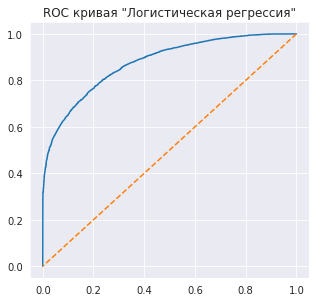

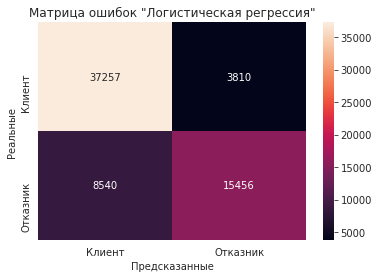

f1: 0.714530072581018
recall: 0.6441073512252042
precision: 0.8022422921208346
accuracy: 0.810183975531408
roc_auc: 0.8766832934708848


In [85]:
# Фиксируем результат и выводим метрики полученной модели
fix_result_model(grid_search.best_estimator_, dt_train_X, dt_train_y, 'Логистическая регрессия')

Модель логистической регрессии обучалась очень быстро, и она смогла достичь довольно высоких показателей. Средняя оценка F1 составила **0.63**, а у самой лучшей модели этот показатель равен **0.71**
<br>

Тем не менее, все еще есть возможности для улучшения, и выбор оптимальных гиперпараметров может еще больше улучшить производительность модели.

#### Модель дерева решений

In [86]:
# Импортируем структуру дерева решений
from sklearn.tree import DecisionTreeClassifier

In [87]:
%%time
# Определяем наиболее важные параметры дерева решений
param_grid = {'max_depth': [5, 10, 20],
              'min_samples_split': [2, 5, 10]}

# Инициализируем модель
model_tree = DecisionTreeClassifier(random_state=222)

# Создаем объект поиска по сетке
grid_search = GridSearchCV(model_tree,param_grid,cv=5,scoring=['f1', 'roc_auc', 'precision', 'recall', 'accuracy'],refit='f1')

# Обучаем
grid_search.fit(dt_train_X, dt_train_y)

CPU times: user 33 s, sys: 127 ms, total: 33.1 s
Wall time: 33.1 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=222),
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_split': [2, 5, 10]},
             refit='f1',
             scoring=['f1', 'roc_auc', 'precision', 'recall', 'accuracy'])

In [88]:
# Выводим показатели
print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Средние оценки модели при кроссвалидации:')
(pd.DataFrame(grid_search.cv_results_)
 .loc[grid_search.best_index_][['mean_test_f1', 'mean_test_roc_auc',
                                'mean_test_precision', 'mean_test_recall','mean_test_accuracy']])

Лучшие гиперпараметры: {'max_depth': 5, 'min_samples_split': 2}
Средние оценки модели при кроссвалидации:


mean_test_f1           0.559181
mean_test_roc_auc      0.678605
mean_test_precision    0.656476
mean_test_recall       0.511463
mean_test_accuracy     0.712355
Name: 0, dtype: object

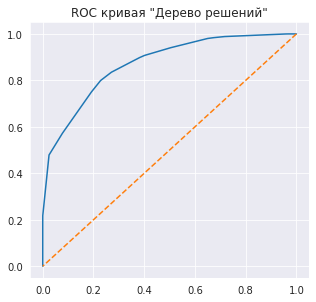

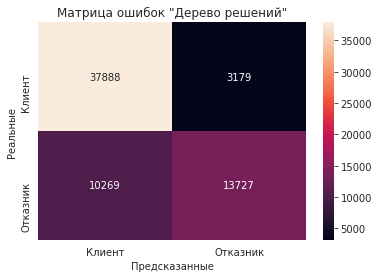

f1: 0.671214121558848
recall: 0.5720536756126021
precision: 0.8119602507985331
accuracy: 0.7933080245300709
roc_auc: 0.8714371258490078


In [89]:
# Фиксируем результат и выводим основные метрики
fix_result_model(grid_search.best_estimator_, dt_train_X, dt_train_y, 'Дерево решений')

Модель дерева решений была обучена относительно быстро и достигла умеренного уровня производительности со средней оценкой F1 **0.55** и лучшей оценкой **0,67**.
<br>

Модель обеспечивает хороший баланс между простотой и точностью, и это хороший выбор для задач, где важна скорость. Однако она может работать не так хорошо, как более сложные модели, такие как случайный лес или CatBoost, в более сложных задачах.

#### Модель случайного леса

In [90]:
# Модель случайного леса
from sklearn.ensemble import RandomForestClassifier
# Для случайного поиска
from sklearn.model_selection import RandomizedSearchCV
# Для работы со списками
import numpy as np

In [91]:
%%time
# Определяем наиболее важные параметры случайного леса
param_grid = {'n_estimators': np.arange(10, 20, 1),
              'max_depth': [5, 10, 20, None],
              'min_samples_split': [2, 5, 10]}

# Инициализируем модель
model_forest = RandomForestClassifier(random_state=777)

# Создаем объект случайного поиска
random_search = RandomizedSearchCV(model_forest,param_grid,n_iter=10,cv=5,
                                   scoring=['f1', 'roc_auc', 'precision', 'recall', 'accuracy'],refit='f1')

# Обучаем
random_search.fit(dt_train_X, dt_train_y)

CPU times: user 1min 26s, sys: 199 ms, total: 1min 26s
Wall time: 1min 29s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=777),
                   param_distributions={'max_depth': [5, 10, 20, None],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
                   refit='f1',
                   scoring=['f1', 'roc_auc', 'precision', 'recall', 'accuracy'])

In [92]:
# Выводим показатели
print('Лучшие гиперпараметры:', grid_search.best_params_)
print('Средние оценки модели при кроссвалидации:')
(pd.DataFrame(grid_search.cv_results_)
 .loc[grid_search.best_index_][['mean_test_f1', 'mean_test_roc_auc',
                                'mean_test_precision', 'mean_test_recall','mean_test_accuracy']])

Лучшие гиперпараметры: {'max_depth': 5, 'min_samples_split': 2}
Средние оценки модели при кроссвалидации:


mean_test_f1           0.559181
mean_test_roc_auc      0.678605
mean_test_precision    0.656476
mean_test_recall       0.511463
mean_test_accuracy     0.712355
Name: 0, dtype: object

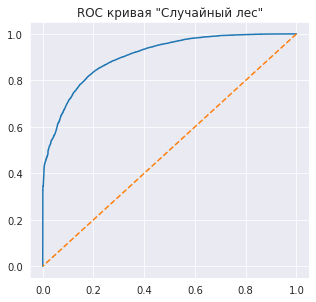

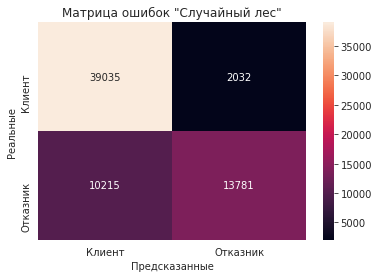

f1: 0.6923559998995201
recall: 0.5743040506751125
precision: 0.8714981344463416
accuracy: 0.8117670565451947
roc_auc: 0.9040263665708719


In [93]:
# Фиксируем результат и выводим основные метрики
fix_result_model(random_search.best_estimator_, dt_train_X, dt_train_y, 'Случайный лес')

Подбор оптимальных гиперпарамеров случайного леча происходит очень долго, из-за большого объема данных обучения. Настройки стоят щадящие, но все равно приходится подождать.<br>

Но стоило ли это таких ожиданий? Как показывают графики и метрики – **ДА**, это очень высокие показатели: средняя F1 - **0.55**, лучшая - **0.68**.

#### Модель CatBoost

In [94]:
# Импортируем кэтбуст
from catboost import CatBoostClassifier

Один из самых лучших плюсов кэтбуста заключается в том, что он хорошо работает и без подбора гиперпараметров. В иной раз ими можно только улучшить результат. Так и тут.
<br>
Были проведены проверки с большим списком гиперапараметров, но качества выше, чем было без гиперпараметров так и не удалось. Поэтому для данной модели мы подбирать ничего не будем.

In [95]:
%%time
model_CatBoost = CatBoostClassifier(silent=True, random_state=111)
model_CatBoost.fit(dt_train_X, dt_train_y)

CPU times: user 15.7 s, sys: 149 ms, total: 15.9 s
Wall time: 16.8 s


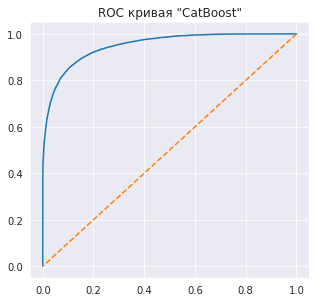

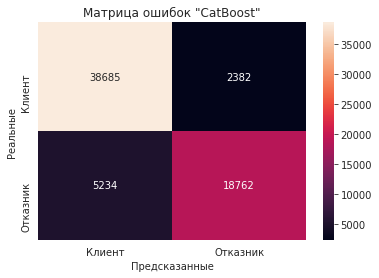

f1: 0.8312804607886576
recall: 0.7818803133855643
precision: 0.8873439273552781
accuracy: 0.8829442232912715
roc_auc: 0.9500026319107989


In [96]:
# Фиксируем результат и выводим основные метрики
fix_result_model(model_CatBoost, dt_train_X, dt_train_y, 'CatBoost')

Модель **CatBoost** была довольно быстрой и эффективной, время работы всего 16,7 секунды.<br>

Метрики, включая **f1**, полноту, точность и **ROC AUC**, показали лучшие результаты.<br>

Средней оценки у нас нет, т.к. кроссвалидацию мы не делали, но у текущей модели, с параметрами по умолчанию, показатель **f1** составил **0.83** – что является рекордным значение для всех остальных выборок.<br>

В целом, модель CatBoost показала себя очень хорошо в этом наборе данных.

#### Сравнение моделей

Итак, посмотрим на результаты работ всех моделей:

In [97]:
# Выводим результаты моделей
models_characteristics.drop('model', axis=1).sort_values(by='F1', ascending=False)

,F1,precision,recall,accuracy,roc_auc
CatBoost,0.831280,0.887344,0.781880,0.882944,0.950003
Логистическая регрессия,0.714530,0.802242,0.644107,0.810184,0.876683
Случайный лес,0.692356,0.871498,0.574304,0.811767,0.904026
Дерево решений,0.671214,0.811960,0.572054,0.793308,0.871437


В результате мы получили модели со следующими показателями:
1.	Лучшая модель по метрике F1 – является **CatBoost**. Значение этого показателя равно **0.83**;
2.	На втором месте логистическая регрессия, её F1 – **0.71**;
3.	На трете место можно поместить две модели, т.к. их F1 довольно схож – **0.67-0.68**.

Теперь сделаем предсказания и вычислим прибыль на тестовой выборке. Для этого напишем небольшую функцию:

In [98]:
# Функция для расчета прибыли:
def calc_profit_on_predict(model, X, name, fix=True):
    '''
    Находит прибыль модели по предсказаниям.
        Параметры:
            model (model): Модель ML.
            X (DataFrame): признаки объектов.
            name (str): название модели.
            fix (bool): сохранять результат в таблицу.
    '''
    # создаем название столбцу
    column_name = 'is_canceled'+name
    # делаем предсказания
    pred = model.predict(X)
    # фиксируем в таблице с прибылью
    dt_test_with_calc_profit[column_name] = pred
    
    # вычисляем профит
    profit = (dt_test_with_calc_profit['profit'].sum()
           + dt_test_with_calc_profit.query(f'{column_name}==1')['deposit'].sum())
    
    # если результат нужно сохранить
    if fix:
        # Профит записываем в новый столбец
        dt_test_with_calc_profit['profit_with_deposit' + name] = dt_test_with_calc_profit['profit'] + (dt_test_with_calc_profit['deposit']
                                                                                                       *dt_test_with_calc_profit[column_name])
    else:
        # удаляем временный столбце
        dt_test_with_calc_profit.drop(columns=[column_name], axis=1)
    
    # возвращаем найденную прибыль
    return profit

In [99]:
# Найдем прибыль для CatBoost
print('Прибыль CatBoost:',
calc_profit_on_predict(models_characteristics.loc['CatBoost', 'model'], dt_test_X, '_CatBoost'))

Прибыль CatBoost: 41996728.0


In [100]:
# Найдем прибыль для Логистическая регрессия
print('Прибыль логистической регрессии:',
calc_profit_on_predict(models_characteristics.loc['Логистическая регрессия', 'model'], dt_test_X, '_LR'))

Прибыль логистической регрессии: 42171080.0


In [101]:
# Найдем прибыль для Случайный лес
print('Прибыль случайного леса:',
calc_profit_on_predict(models_characteristics.loc['Случайный лес', 'model'], dt_test_X, '_RF'))

Прибыль случайного леса: 38664472.0


In [102]:
# Найдем прибыль для Дерево решений
print('Прибыль дерева решений:',
calc_profit_on_predict(models_characteristics.loc['Дерево решений', 'model'], dt_test_X, '_DT'))

Прибыль дерева решений: 39055264.0


In [103]:
dt_test_with_calc_profit[['profit', 'profit_with_deposit_CatBoost', 
                          'profit_with_deposit_LR', 'profit_with_deposit_RF', 
                          'profit_with_deposit_DT']].sum().to_frame()

,0
profit,32556440.0
profit_with_deposit_CatBoost,41996728.0
profit_with_deposit_LR,42171080.0
profit_with_deposit_RF,38664472.0
profit_with_deposit_DT,39055264.0


Получили такие данные. Как оказалось логистическая регрессия заработала больше прибыли, чем CatBoost, но возможно, что она также неправильно пометила множество клиентов, которые бы не отказали.<br>

Посмотрим на матрицу ошибок, которая есть в нашей функции:

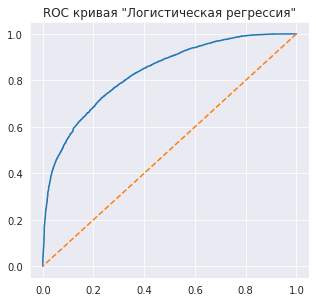

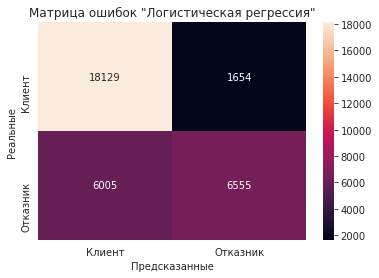

f1: 0.6312292358803987
recall: 0.5218949044585988
precision: 0.7985138262882202
accuracy: 0.7631945088581764
roc_auc: 0.8326479624788832


In [104]:
# Фиксируем результат и выводим основные метрики
fix_result_model(models_characteristics.loc['Логистическая регрессия', 'model'],
                 dt_test_X, dt_test_y, 'Логистическая регрессия', fix=False)

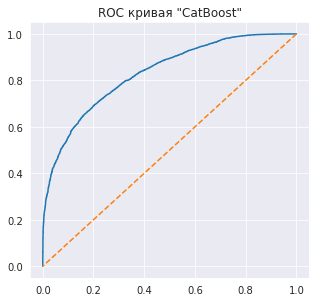

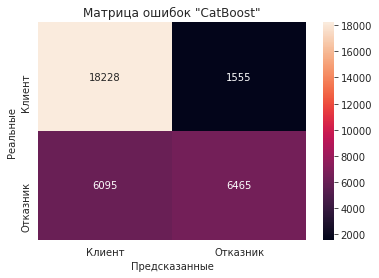

f1: 0.6282798833819242
recall: 0.5147292993630573
precision: 0.8061097256857855
accuracy: 0.7634727761803172
roc_auc: 0.8319071902273425


In [105]:
# Фиксируем результат и выводим основные метрики
fix_result_model(models_characteristics.loc['CatBoost', 'model'],
                 dt_test_X, dt_test_y, 'CatBoost', fix=False)

Как видим, логистическая регрессия действительно пометила больше клиентов которые не являются отказниками и recall у нее больше, чем у CatBoost. Т.к. мы не знаем, как неверно помеченные клиенты влияют на прибыль, то выигрывает логистическая регрессия, но если начнётся отток клиентов из-за нового правила, то лучше использовать catboost

### Шаг 5. Опишите портрет «ненадёжного» клиента

К сожалению, с текущими данными и моделями, мы не можем посмотреть какие параметры модель выделила больше всего. Мы использовали прямое кодирование, из-за чего все наименования столбцов пропали.

Сделаем аналогичную операцию, но используем порядковое кодирование и посмотрим, какие модель выявит закономерности:

In [106]:
# Для категориальных признаков
from sklearn.preprocessing import OrdinalEncoder
# Для конвертации типа
import catboost

In [107]:
# Удалим столбце ID, который не понадобится нам в обучении модели,
# Сохраним данные в отдельной переменной
dt_train_X = dt_train.drop(['id', 'is_canceled'], axis=1).copy()
dt_test_X = dt_test.drop(['id', 'is_canceled'], axis=1).copy()

# Определяем список категориальных значений
categorical_features = dt_train_X.select_dtypes(include='object').columns
# Создаем объект кодирования
categorical_transformer = OrdinalEncoder(handle_unknown='ignore')

# Трансформируем обучающую и тестовую выборку
categorical_transformer.fit(pd.concat([dt_train_X[categorical_features], dt_test_X[categorical_features]]))

# Сохраняем имена столбцов
feature_names = dt_train_X.columns

# Конвентируем
dt_train_X[categorical_features] = categorical_transformer.transform(dt_train_X[categorical_features])
dt_test_X[categorical_features] = categorical_transformer.transform(dt_test_X[categorical_features])

# Трансформируем обучающую и тестовую выборку
train_pool = catboost.Pool(data=dt_train_X, label=dt_train_y)

# Обучаем модель
model_CatBoost = CatBoostClassifier(silent=True, random_state=111)
model_CatBoost.fit(dt_train_X, dt_train_y)

# Конвертируем в тип кэтбуста, а затем в дадафрейм
feature_importances = pd.DataFrame([model_CatBoost.get_feature_importance(data=train_pool, type='FeatureImportance')], columns=feature_names).T

# Смотрим на показатели модели
# fix_result_model(model_CatBoost, dt_test_X, dt_test_y, 'CatBoost', dt_test)

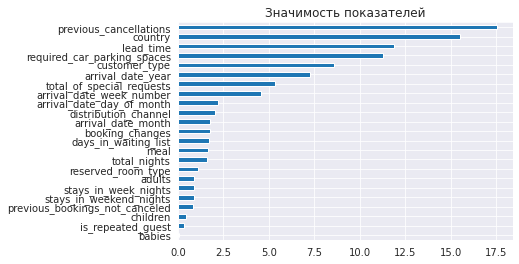

In [108]:
# Выводим график показателей
feature_importances.sort_values(by=0,ascending=True).plot(kind= 'barh', legend=False, title='Значимость показателей');

Вот как модель видит **ненадежного клиента**:
1.	В первую очередь проверяется предыдущие действия клиента. Если он уже раньше делал заказ, а по итогу сделал отказ, то это сильный сигнал, чтобы на этот раз заставить его платить депозит.
2.	На втором месте стоит обратить внимание на страну. Нам не известны все подробности, но почему-то именно из Португалии самый высокий процент клиентов, а также очень большой отказников.
3.	Если у человека есть машина, то вероятнее всего он останется в отеле. По крайней мере исторические данные этому не противоречат.
4.	Далее идут менее значимые поля, которые были выделены моделью на основе большинства, но это не факт что данные факторы реально влияют на поведение клиента.


### Шаг 6. Напишите общий вывод

Все модели показали себя достаточно хорошо и можно использовать любую из них, но это зависит от бизнеса.
Мы не знаем всех входных условие, поэтому конечное слово было бы за руководителем отеля, но вот несколько рекомендаций:
- Если нужна максимальная прибыль без убытка – то можно даже без модели, внедрить систему депозитов. В таком случае, никогда не будет ситуации с убытком.
- Если такое решение не подходит, например, такое условие окажется непривлекательным для клиентов, тогда следует выбрать систему с подходящим уровнем точности. Нужно определить, на сколько важнее в данном случае метрика точности и полноты и найти между ними баланс.
- Самой гибкой моделью, является catboost. Её F1 составляет **0.83**, что выше всех остальных моделей. Это означает, что её порог можно настроить под конкретные цели: либо максимальная точность, либо более полный охват.
- В любом случае, при выборе одной из рекомендаций, прибыль должна возрасти. Вспомним, что на **2017 г**., без учета системы прибыль составляла **32 млн**, из-за убытков в **18 млн** связанных с отказами. При вводе системы в экспликацию мы увеличиваем прибыль с худшей моделью **19%** и на **30%** с лучшей.